In [2]:
suppressPackageStartupMessages({
    library(HGNChelper)
    library(stringr)
    library(tidyverse)
    library(limma)
    library(GSVA)
    library(edgeR)
    library(ggsignif)
})

Warning message:
“package ‘limma’ was built under R version 4.1.3”
Warning message:
“package ‘edgeR’ was built under R version 4.1.3”


For GTEx we included the metadata from the file “GTEx Data V6 Annotations 
SampleAttributesDS.txt” available from http://www.gtexportal.org/home/datasets. For TCGA, 
we consolidated metadata from three sources: a query via the Genomic Data Commons 
(GDC) API (https://gdc.cancer.gov/developers), queries via the CGC API39, and queries 
using TCGAbiolinks42. We merged the information from all three sources and found 
metadata information for 11,285 samples (including the sample that we later discarded). For 
each sample we normalized the coverage to 40 million 100 base-pair reads using the AUC 
information. We then computed the base-level coverage sum for each project using the 
sample normalized coverage with bwtool40 version 1.0 and divided the coverage sum by the 
number of samples in the project resulting in the project mean coverage. We then stored the 
mean coverage for each SRA project in a BigWig file37. The mean coverage can then be 
used to identify expressed regions with derfinder23 via the recount Bioconductor package. 
The code and log files for creating these files as well as the recount2 website are available 
at https://github.com/leekgroup/recount-website (Supplementary Code 4).

In [3]:
normals <- c(
    "BRCA" = "BREAST",
    "COAD" = "COLON",
    "READ" = "COLON",
    "ESCA" = "ESOPHAGUS",
    "LIHC" = "LIVER",
    "LUAD" = "LUNG",
    "PAAD" = "PANCREAS",
    "PRAD" = "PROSTATE",
    "STAD" = "STOMACH"
)
presigs <- c(
    'STAD' = 'M5',
    'BRCA' = 'M4',
    'CRC' = 'M9',
    'ESCA' = 'M1',
    'LIHC' = 'M2',
    'LUAD' = 'M1',
    'PAAD' = 'M4',
    'PRAD' = 'M6'
)
cancer_types <- names(normals)

In [4]:
cancer <- "COAD"
dt.tcga <- get(load(paste0(cancer, ".RData")))
dt.gtex <- get(load(paste0(normals[cancer], ".RData")))

cancer.alias <- "CRC"
sigs <- read.table(paste0("/data/egc21/data_db/6.signature.v1.6.median/", cancer.alias, ".txt"), header = T)[[presigs[[cancer.alias]]]]

In [5]:
metadata <- dt.tcga@colData
keywords <- c("type", "patho", "histo", "molecu", "sub")
nn <- names(dt.tcga@colData)[grepl(paste(keywords, collapse = "|"), names(dt.tcga@colData))]
tt <- lapply(nn, function(x) {
    tmp <- table(dt.tcga@colData[[x]])
    if(length(tmp) < 30 & length(tmp) > 1) {tmp} else{NA}
})
names(tt) <- nn
tt <- tt[!is.na(tt)]
tt

$tcga.cgc_sample_sample_type

         Metastatic       Primary Tumor     Recurrent Tumor Solid Tissue Normal 
                  1                 503                   1                  41 

$tcga.gdc_cases.samples.sample_type_id

  1   2   6  11 
503   1   1  41 

$tcga.gdc_cases.samples.sample_type

         Metastatic       Primary Tumor     Recurrent Tumor Solid Tissue Normal 
                  1                 503                   1                  41 

$tcga.cgc_sample_sample_type_code

  1   2   6  11 
503   1   1  41 

$tcga.cgc_case_pathologic_n

 N0  N1 N1a N1b N1c  N2 N2a N2b 
326  86  16  18   2  73   8  14 

$tcga.cgc_case_histological_diagnosis

         Colon Adenocarcinoma Colon Mucinous Adenocarcinoma 
                          466                            72 

$tcga.cgc_case_pathologic_stage

   Stage I   Stage IA   Stage II  Stage IIA  Stage IIB  Stage IIC  Stage III 
        89          1         42        163         12          1         26 
Stage IIIA Stag

In [6]:
tcgagtexCnt <- cbind(dt.tcga[, dt.tcga$tcga.gdc_cases.samples.sample_type %in% c("Primary Tumor", "Solid Tissue Normal")]@assays@data$raw_counts[,],
     dt.gtex@assays@data$raw_counts[,])
tgDGE = DGEList(tcgagtexCnt)
sampleTCGA <- intersect(rownames(tgDGE$samples), colnames(dt.tcga))
tgDGE$samples$group <- "Normal"
TCGASampleType <- c("Primary Tumor" = "Tumor", "Solid Tissue Normal" = "Adjecent")
tgDGE$samples[sampleTCGA,]$group <- TCGASampleType[dt.tcga@colData[sampleTCGA, 'tcga.cgc_sample_sample_type']]

In [8]:
duplicated.gene <- table(dt.tcga@rowRanges$gene_name) %>% .[.>1] %>% names
head(duplicated.gene)

[1] "5_8S_rRNA"   "5S_rRNA"     "7SK"         "AADACL2"     "AADACL2-AS1"
[6] "AATF"

In [7]:
TPM.gene_name.1 <- TPM.gene_name %>% filter(!gene_name %in% duplicated.gene)
TPM.gene_name.2 <- TPM.gene_name %>% filter(gene_name %in% duplicated.gene) %>%
    group_by(gene_name) %>%
    summarise(across(where(is.numeric), sum))

ERROR: Error in filter(., !gene_name %in% duplicated.gene): 找不到对象'TPM.gene_name'


In [120]:
ssgsea.results <- gsva(as.matrix(TPM.gene_name.final), data.frame(sigs), method = "ssgsea", ssgsea.norm = T)

Estimating ssGSEA scores for 1 gene sets.
  |======================================================================| 100%



In [161]:
ssgsea.data <- data.frame(t(ssgsea.results))
ssgsea.data$group <- factor(tgDGE$samples[rownames(ssgsea.data),]$group, levels = c("Normal", "Adjecent", "Tumor"))
table(ssgsea.data$group)
ssgsea.data <- ssgsea.data %>%
#     filter(group != "Adjecent") %>%
    mutate(score = as.numeric(scale(sigs)))
head(ssgsea.data)


  Normal Adjecent    Tumor 
     822       41      503 

,sigs,group,score
,<dbl>,<fct>,<dbl>
98c8f873-7132-4781-ab24-a7461e1c8d02,1.472960,Tumor,0.6429297
ffa5fff7-6301-4cd8-8e63-a4d8294d1b0e,1.553894,Tumor,0.9751959
29e8adb9-3f5d-497a-9a6b-85218ae2db14,1.593568,Tumor,1.1380739
2ebc7be8-627b-4767-a4fe-14e933e40c1c,1.643312,Tumor,1.3422904
70969845-95d5-4324-ae22-8d8cd725021d,1.575953,Tumor,1.0657578
196281bd-2c05-46d3-a53c-ead8639ef02d,1.578908,Tumor,1.0778883


In [276]:
ssgsea.data.tumor <- ssgsea.data %>% filter(group == "Tumor") %>%
    rownames_to_column("external_id") %>%
    inner_join(dt.tcga@colData %>% data.frame, by = "external_id")
keywords <- c("tcga.cgc_case_histological_diagnosis", "tcga.cgc_case_pathologic_stage", "tcga.xml_histological_type", "tcga.xml_stage_event_pathologic_stage", "tcga.xml_anatomic_neoplasm_subdivision")

Warning message:
“Removed 565 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 565 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 17 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 17 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 17 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 17 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 18 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 18 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 17 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 17 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 16 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 16 rows containing non-finite values (stat_signif).”


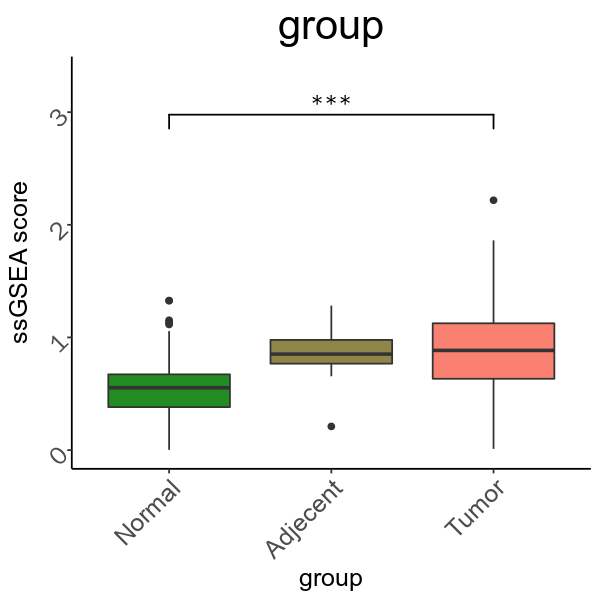

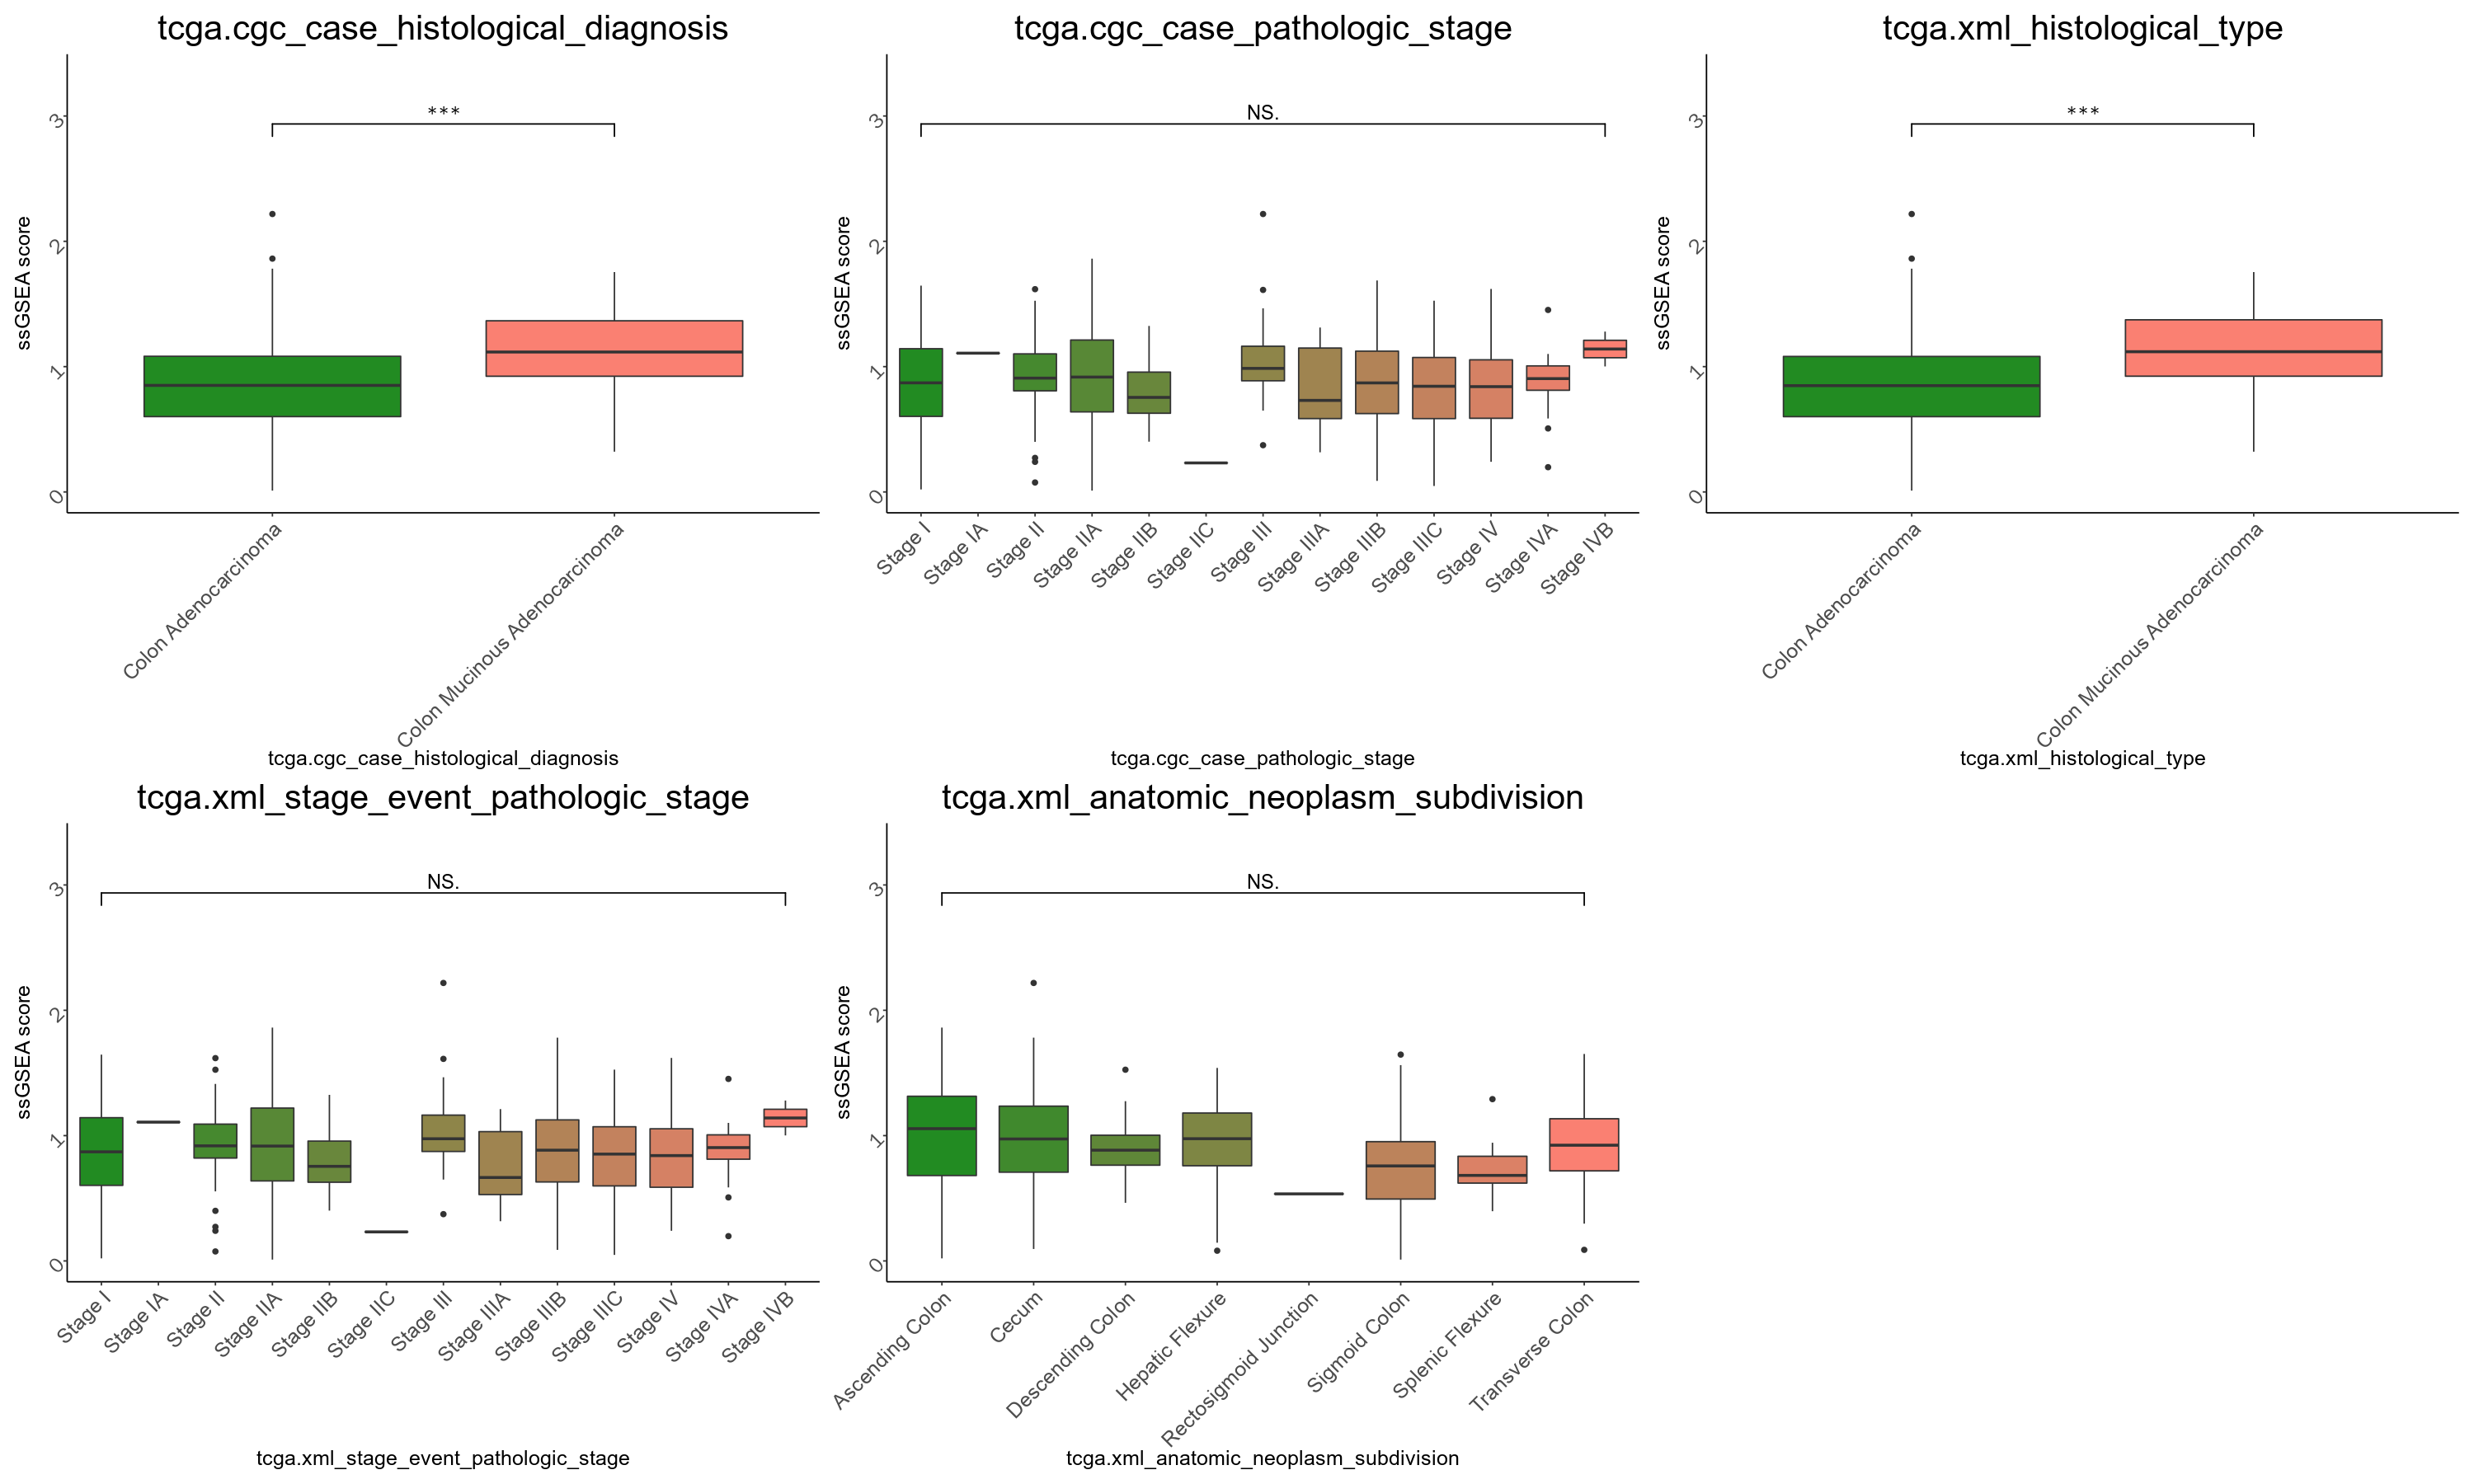

In [275]:


my_boxplot <- function(dt, value, gg){
    dt <- dt[!is.na(dt[[gg]]),]
    groups <- sort(unique(dt[[gg]]))
    mm = max(dt[[value]])
    nn = length(groups)
    ggplot(dt, aes(x = .data[[gg]], y = .data[[value]])) +
        geom_boxplot(aes(fill = .data[[gg]])) +
        scale_fill_manual(values = colorRampPalette(c("#228B22", "#FA8072"))(nn)) +
        labs(y = "ssGSEA score", title = gg) +
        geom_signif(
            comparisons = list(c(groups[length(groups)], groups[1])),
            test = wilcox.test,
            test.args = list(
                alternative = "two.sided",
                var.equal = FALSE,
                paired=FALSE),
            map_signif_level = T,
            textsize = 5,
            y_position = mm*1.25) +
        theme(
            panel.background = element_blank(),
            axis.line = element_line()) +
        theme(plot.title = element_text(hjust = 0.5, size = 25)) +
        theme(axis.text = element_text(size = 15, angle = 45, hjust = 1), axis.title = element_text(size = 15)) +
        scale_y_continuous(limits = c(0, mm*1.5)) +
        theme(legend.position = 'none') +
        NULL
}
options(repr.plot.height = 5, repr.plot.width = 5)
my_boxplot(ssgsea.data, "score", "group")
options(repr.plot.height = 15, repr.plot.width = 25)
patchwork::wrap_plots(lapply(keywords, function(x) {my_boxplot(ssgsea.data.tumor, "score", x)}))

Warning message:
“Removed 565 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 565 rows containing non-finite values (stat_signif).”


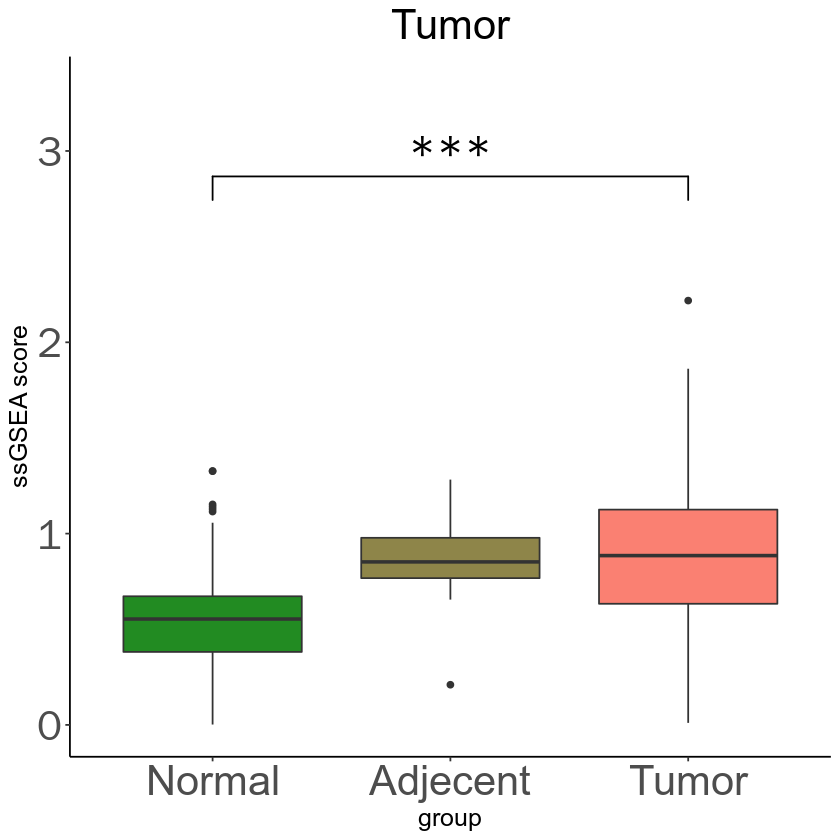

In [181]:
ggplot(ssgsea.data, aes(x = group , y = score )) +
    geom_boxplot(aes(fill = group)) +
    scale_fill_manual(values = colorRampPalette(c("#228B22", "#FA8072"))(3)) +
    labs(y = "ssGSEA score", title = group) +
    geom_signif(
        comparisons = list(c('Tumor','Normal')),
        test = wilcox.test,
        test.args = list(
            alternative = "two.sided",
            var.equal = FALSE, paired=FALSE),
        map_signif_level = T,
        textsize = 10,
        y_position = max(c(ssgsea.data$score))*1.2) +
    theme(
        panel.background = element_blank(),
        axis.line = element_line()) +
    theme(plot.title = element_text(hjust = 0.5, size = 25)) +
    theme(axis.text = element_text(size = 25), axis.title = element_text(size = 15)) +
    scale_y_continuous(limits = c(0, max(c(ssgsea.data$score))*1.5)) +
    theme(legend.position = 'none') +
    NULL

In [126]:
# pp.list = list()
# for(i in 1:length(good.cell)){
#     type = good.cell[i]
#     hot = full[grep('Hot',full$Mixture),colnames(full) == type]
#     cold = full[grep('Cold',full$Mixture),colnames(full) == type]
#     dttt = rbind(data.frame(hot, 'Hot'), data.frame(cold, 'Cold'))
#     colnames(dttt) = c('value', 'site')
#     dttt$site = factor(dttt$site, levels = c('Hot', 'Cold'), ordered = T)
#     p = (ggplot(dttt, aes(x = site , y = value )) + geom_boxplot(aes(fill = site)) + scale_fill_manual(values = c('#FA8072', '#228B22')) 
#                  + labs(y = "Proportion", title = type)
#                  + geom_signif(comparisons = list(c('cancer','normal')), test = wilcox.test, test.args = list(alternative = "two.sided", var.equal = FALSE, paired=FALSE),map_signif_level = T, textsize = 10, y_position = max(c(dttt$value))*1.5)
#                  + theme(panel.background = element_blank(),axis.line = element_line())+  theme(plot.title = element_text(hjust = 0.5, size = 25)) 
#                  + theme(axis.text = element_text(size = 25), axis.title = element_text(size = 15)) 
#                  + scale_y_continuous(limits = c(0, max(c(dttt$value))*2))
#                  + theme(legend.position = 'none')
#                  )
#     pp.list[[i]] = p
# }


Adjecent   Normal    Tumor 
      41      822      503 

In [122]:
dt.tcga@rowRanges %>% data.frame %>% filter(gene_name %in% sigs) %>% pull(gene_type) %>% table

.
processed_transcript       protein_coding 
                   1                  108 

In [277]:
library(WGCNA)

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:IRanges’:

    cor


The following object is masked from ‘package:S4Vectors’:

    cor


The following object is masked from ‘package:stats’:

    cor




In [303]:
dataExpr0 <- v$E
# head(dataExpr0[,1:6])
dataExpr1 <- data.frame(dataExpr0[,rownames(tgDGE$samples %>% filter(group == "Tumor"))])
colnames(dataExpr1) <- rownames(tgDGE$samples %>% filter(group == "Tumor"))
# head(dataExpr1[,1:6])
dataExpr1$Count <- rowSums(dataExpr1 < 0)
# table(dataExpr1$Count)
dataExpr2 <- dataExpr1 %>% filter(Count == 0)
dataExpr2$Count <- NULL
dataExpr3 <- as.data.frame(t(dataExpr2))

In [305]:
head(dataExpr3[1:6])

,ENSG00000225630.1,ENSG00000278791.1,ENSG00000237973.1,ENSG00000229344.1,ENSG00000248527.1,ENSG00000198744.5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
98c8f873-7132-4781-ab24-a7461e1c8d02,9.148487,6.166879,9.958917,6.168066,9.390537,7.713409
ffa5fff7-6301-4cd8-8e63-a4d8294d1b0e,7.911541,4.368949,10.388350,5.534820,9.364244,7.357493
29e8adb9-3f5d-497a-9a6b-85218ae2db14,10.887631,7.951625,11.671582,8.589823,11.388361,9.258829
2ebc7be8-627b-4767-a4fe-14e933e40c1c,9.431381,6.302217,10.533483,5.929480,8.956986,7.395914
70969845-95d5-4324-ae22-8d8cd725021d,8.536053,8.126061,11.070625,6.292882,10.429586,7.986835
196281bd-2c05-46d3-a53c-ead8639ef02d,9.373086,4.734138,10.694242,7.001444,9.560718,8.841526


In [306]:
gsg <- goodSamplesGenes(dataExpr3, verbose = 3)

 Flagging genes and samples with too many missing values...
  ..step 1


In [307]:
gsg$allOK

[1] TRUE

In [308]:
if (sum(!gsg$goodGenes) > 0) {
    printFlush(paste("Removing genes:", paste(names(dataExpr3)[!gsg$goodGenes], collapse = ", ")))
}
if (sum(!gsg$goodSamples) > 0) {
    printFlush(paste("Removing samples:", paste(rownames(dataExpr3)[!gsg$goodSamples], collapse = ", ")))
}

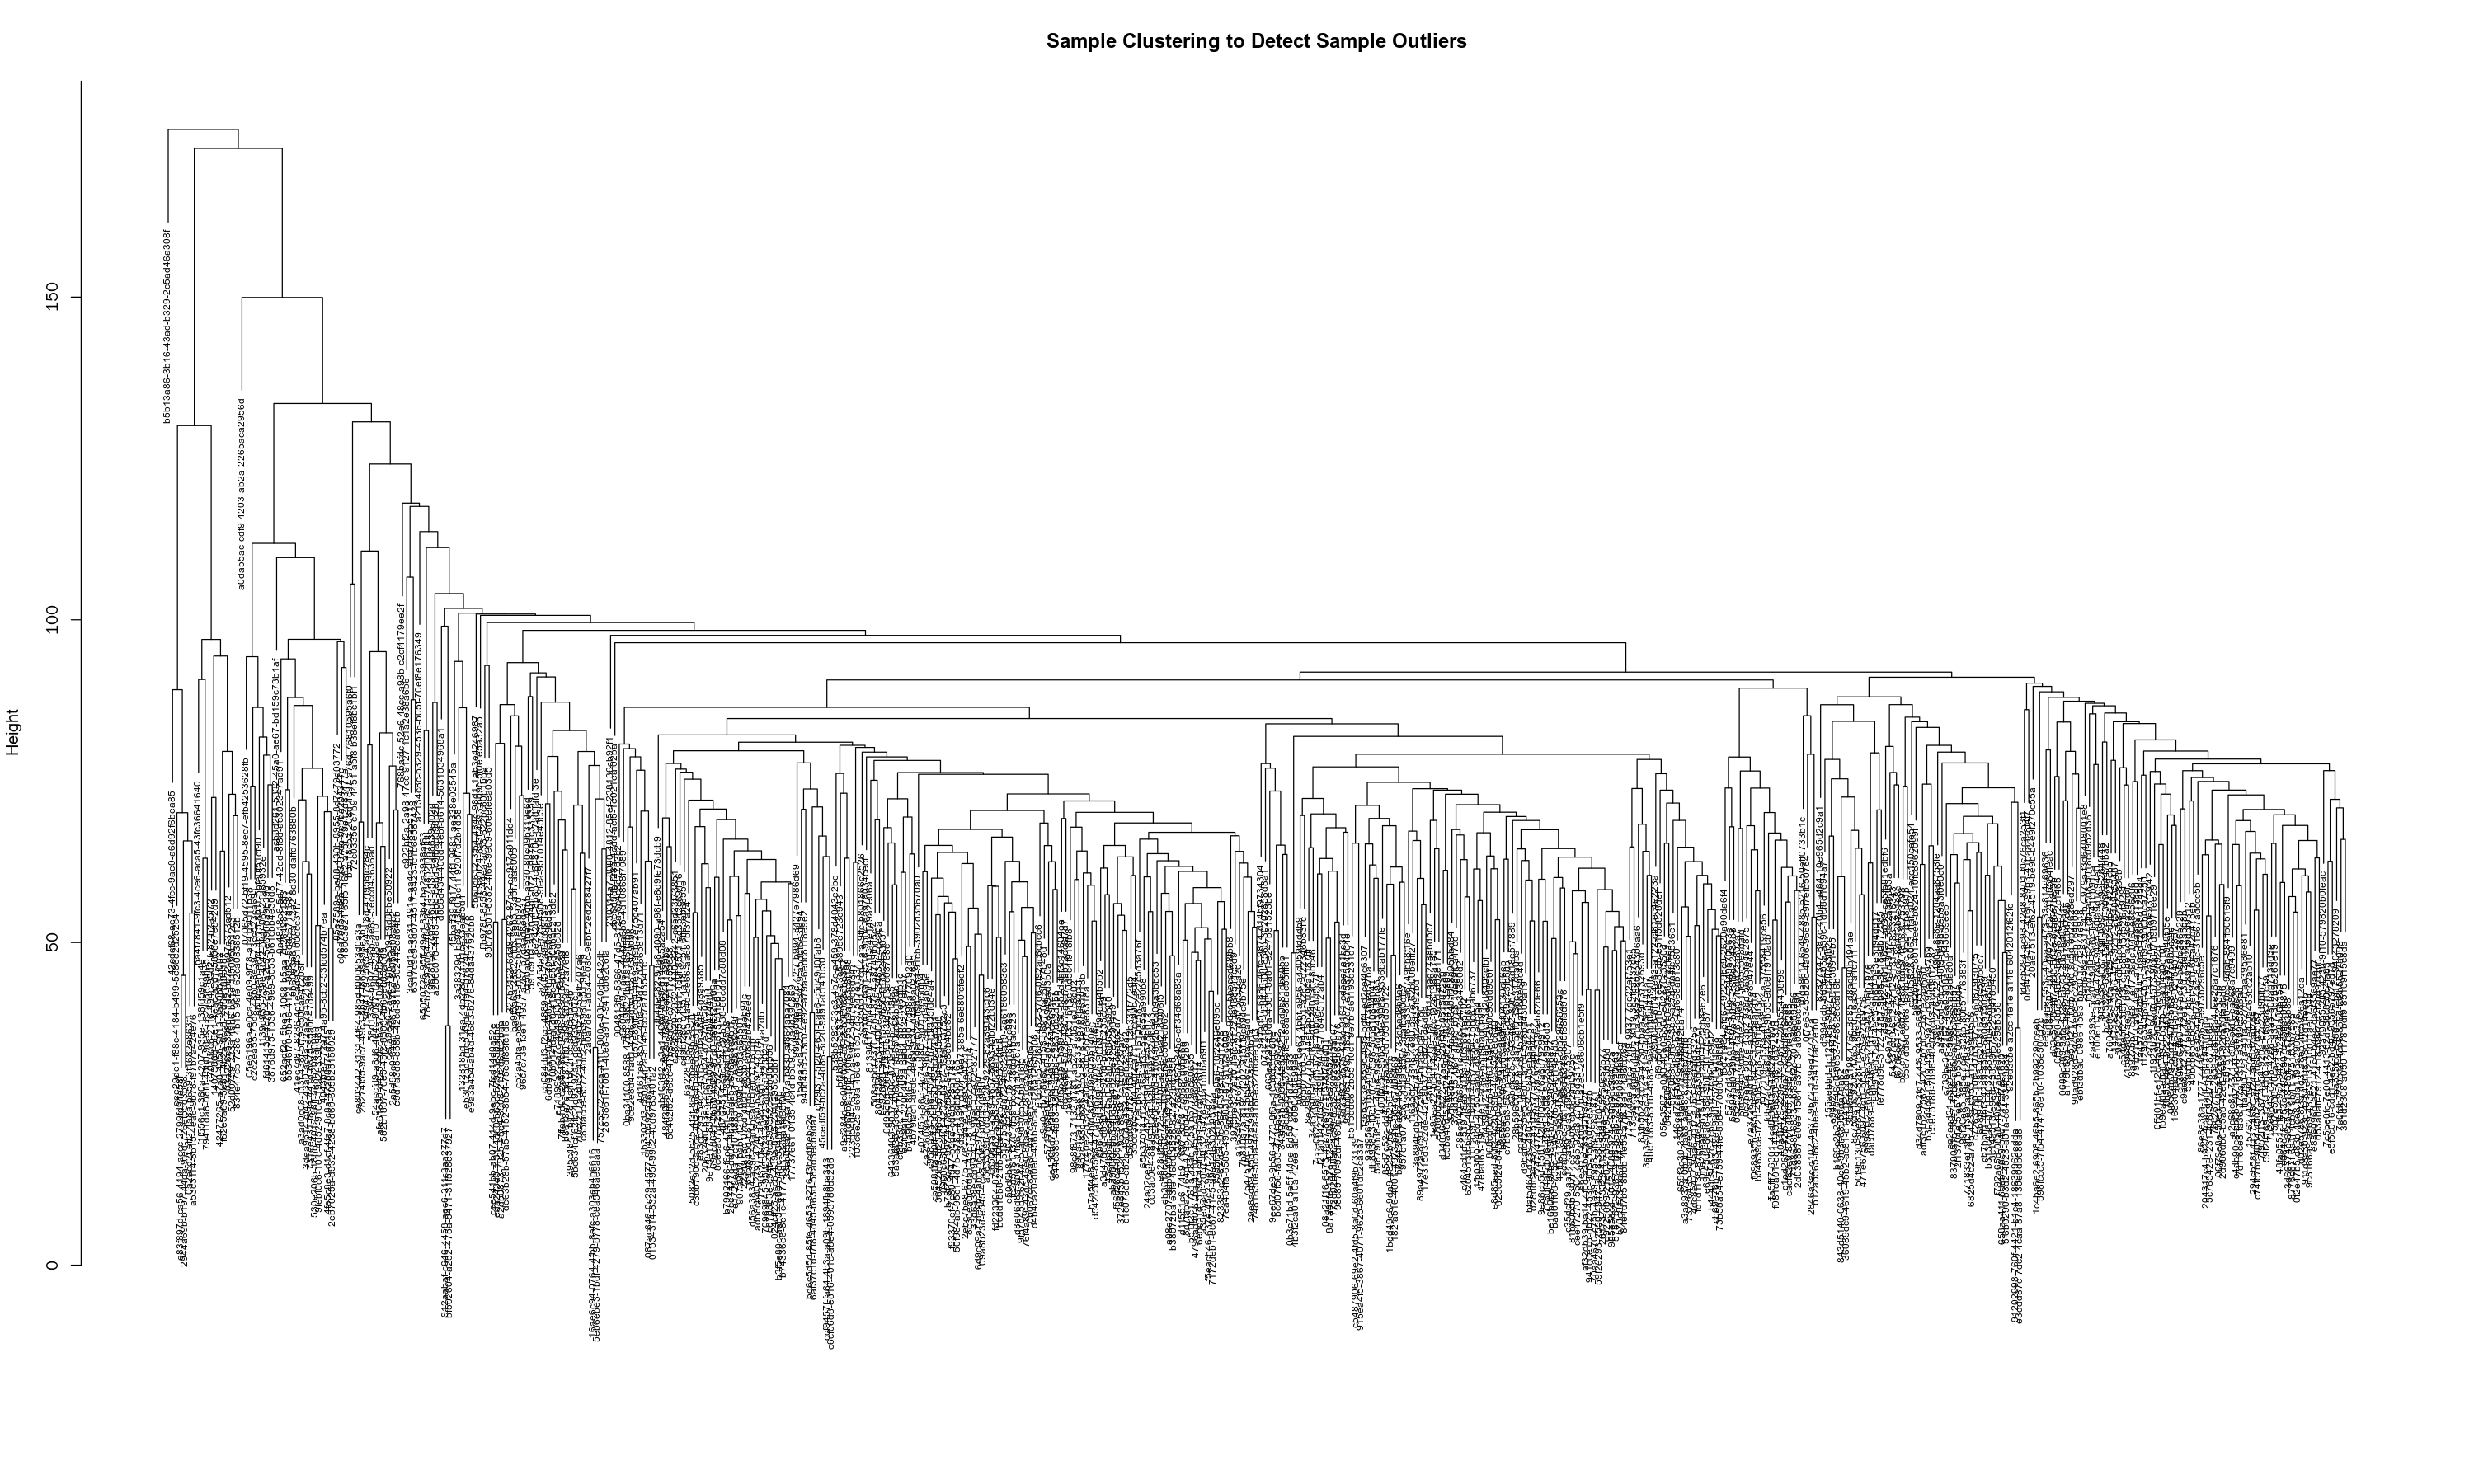

In [309]:
sampleTree <- hclust(dist(dataExpr3), method = "average")
plot(sampleTree, main = "Sample Clustering to Detect Sample Outliers", sub = "", xlab = "", cex = 0.6)

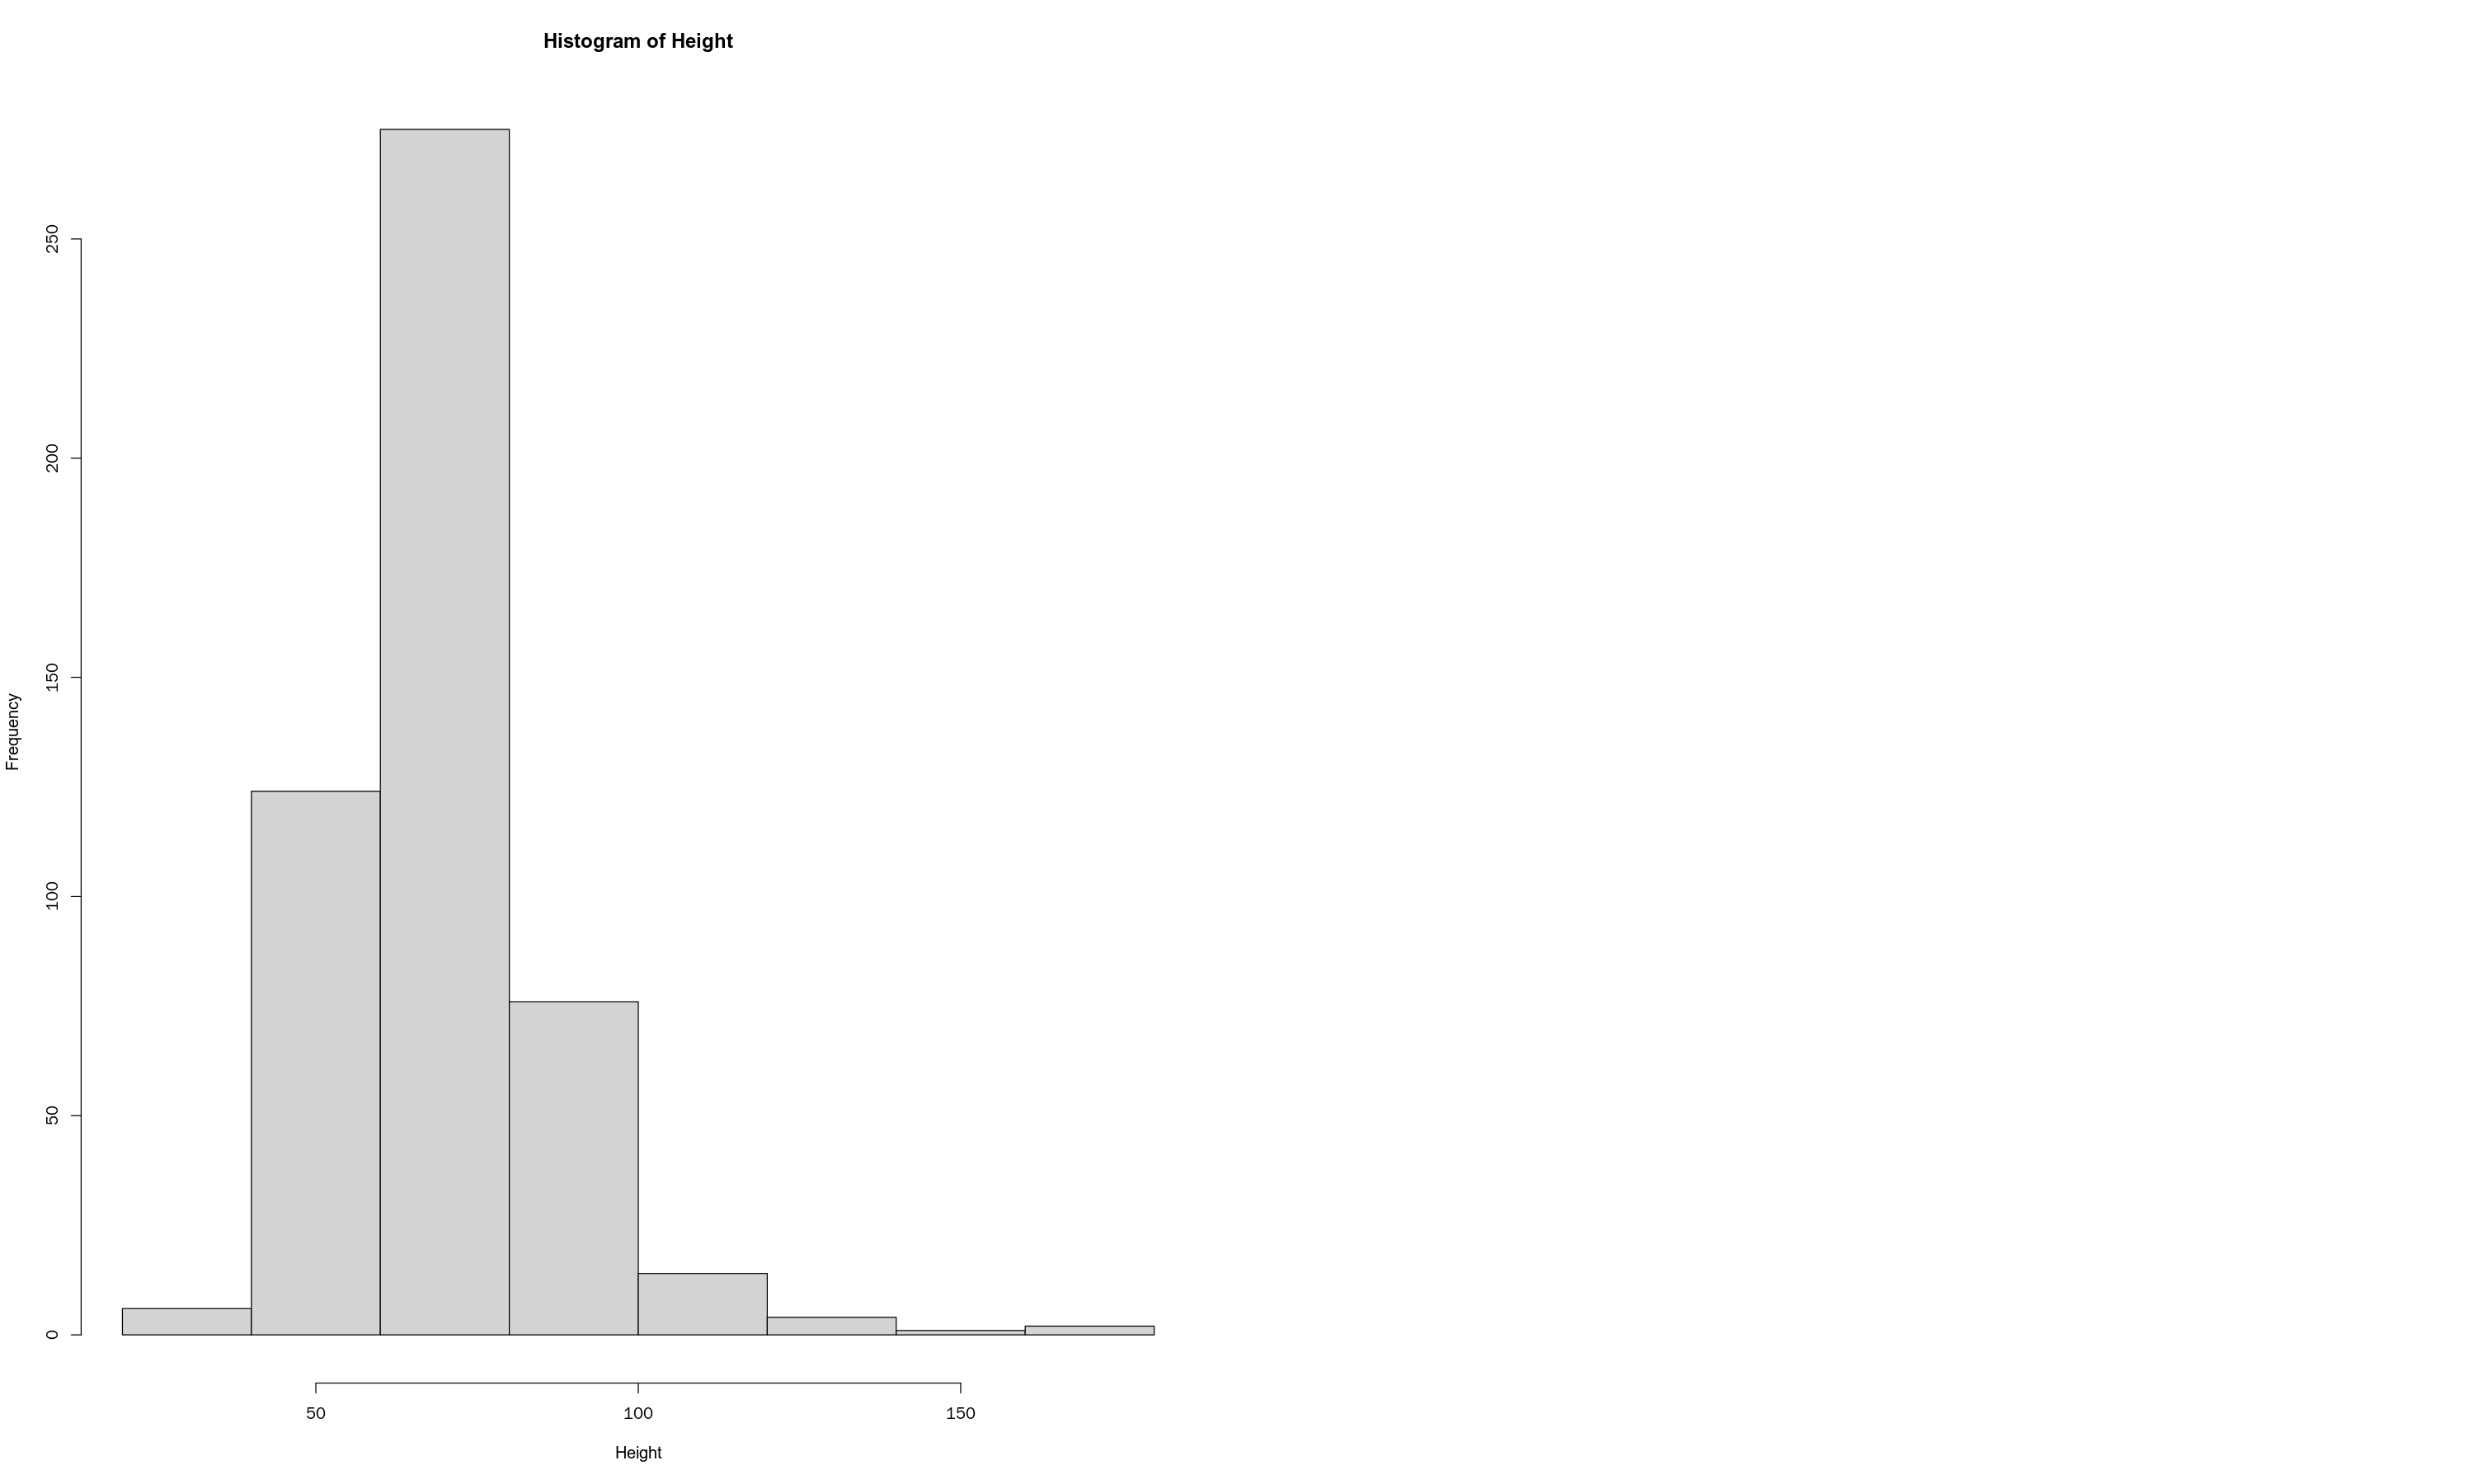

In [313]:
par(mfrow = c(1, 2))
byHist <- hist(sampleTree$height, main = "Histogram of Height", xlab = "Height")

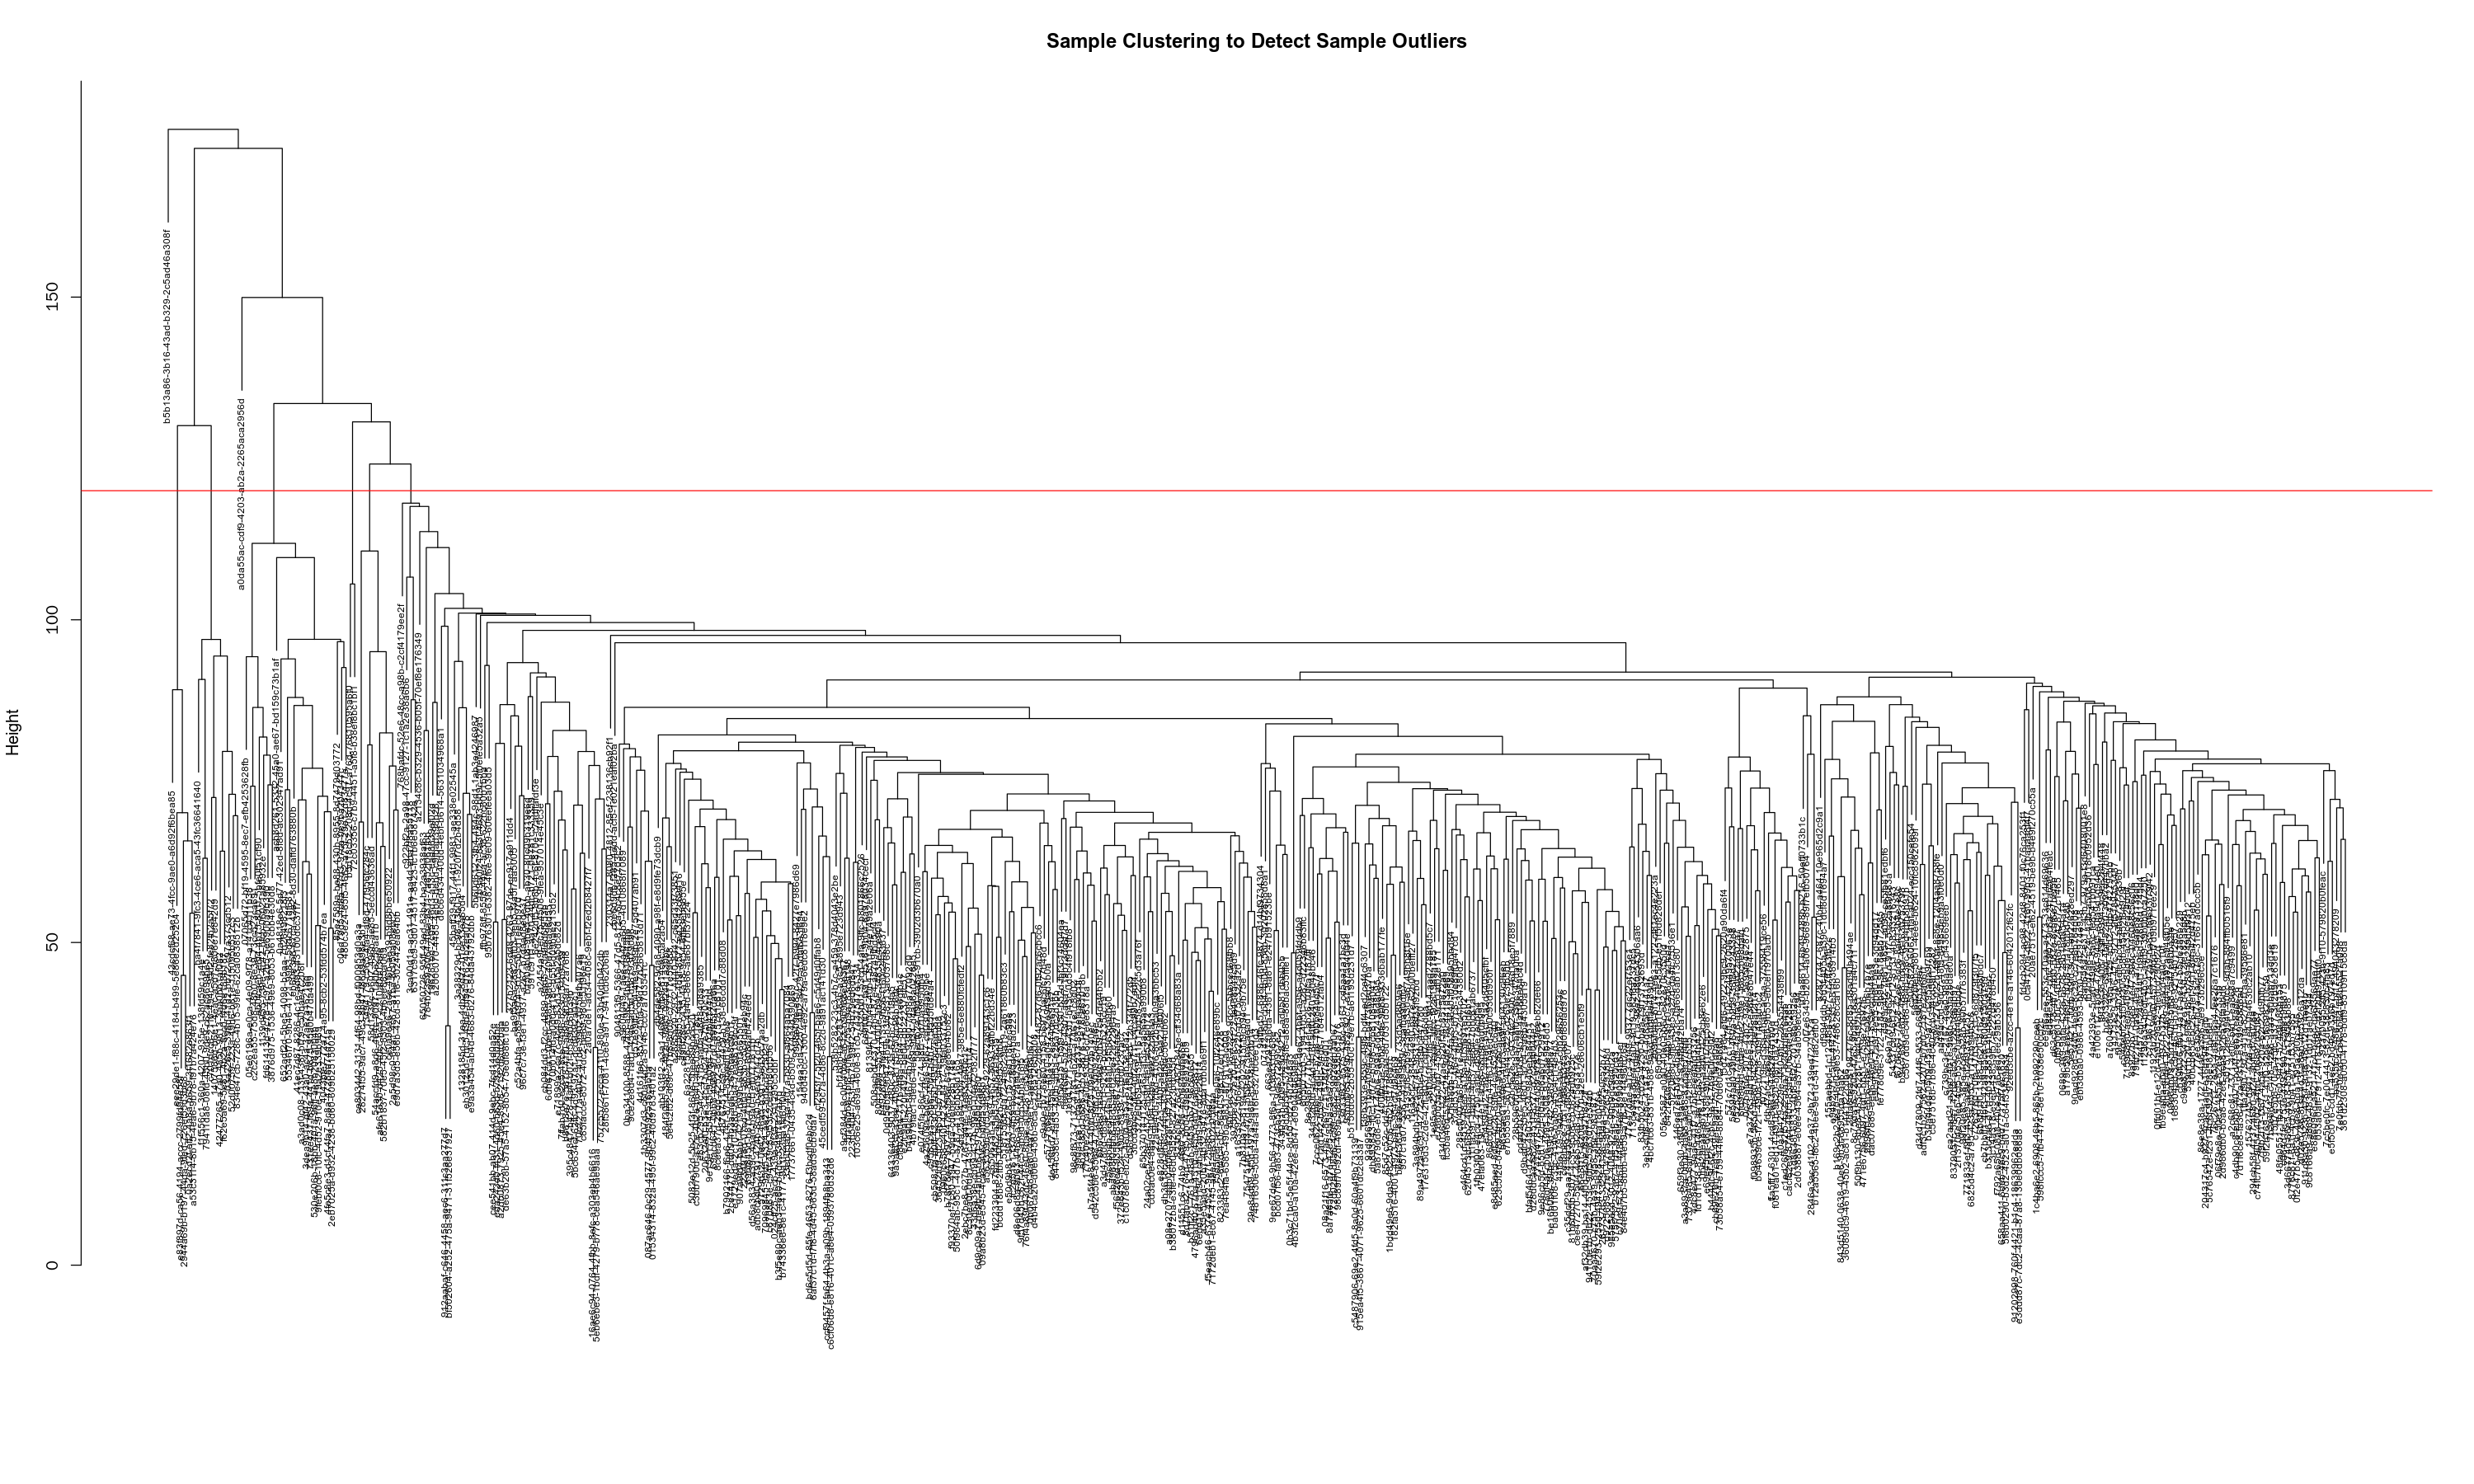

In [314]:
plot(sampleTree, main = "Sample Clustering to Detect Sample Outliers", sub = "", xlab = "", cex = 0.6)
abline(h = 120, col = "red")

In [318]:
clust = cutreeStatic(sampleTree, cutHeight = 120, minSize = 10)
table(clust)

clust
  0   1   2   3   4 
 10 449  24  10  10 

In [321]:
keepSamples <- (clust == 1)
dataExpr4 <- dataExpr3[keepSamples,]
nGenes <- ncol(dataExpr4)
nSamples <- nrow(dataExpr4)
nGenes
nSamples

[1] 10667

[1] 449

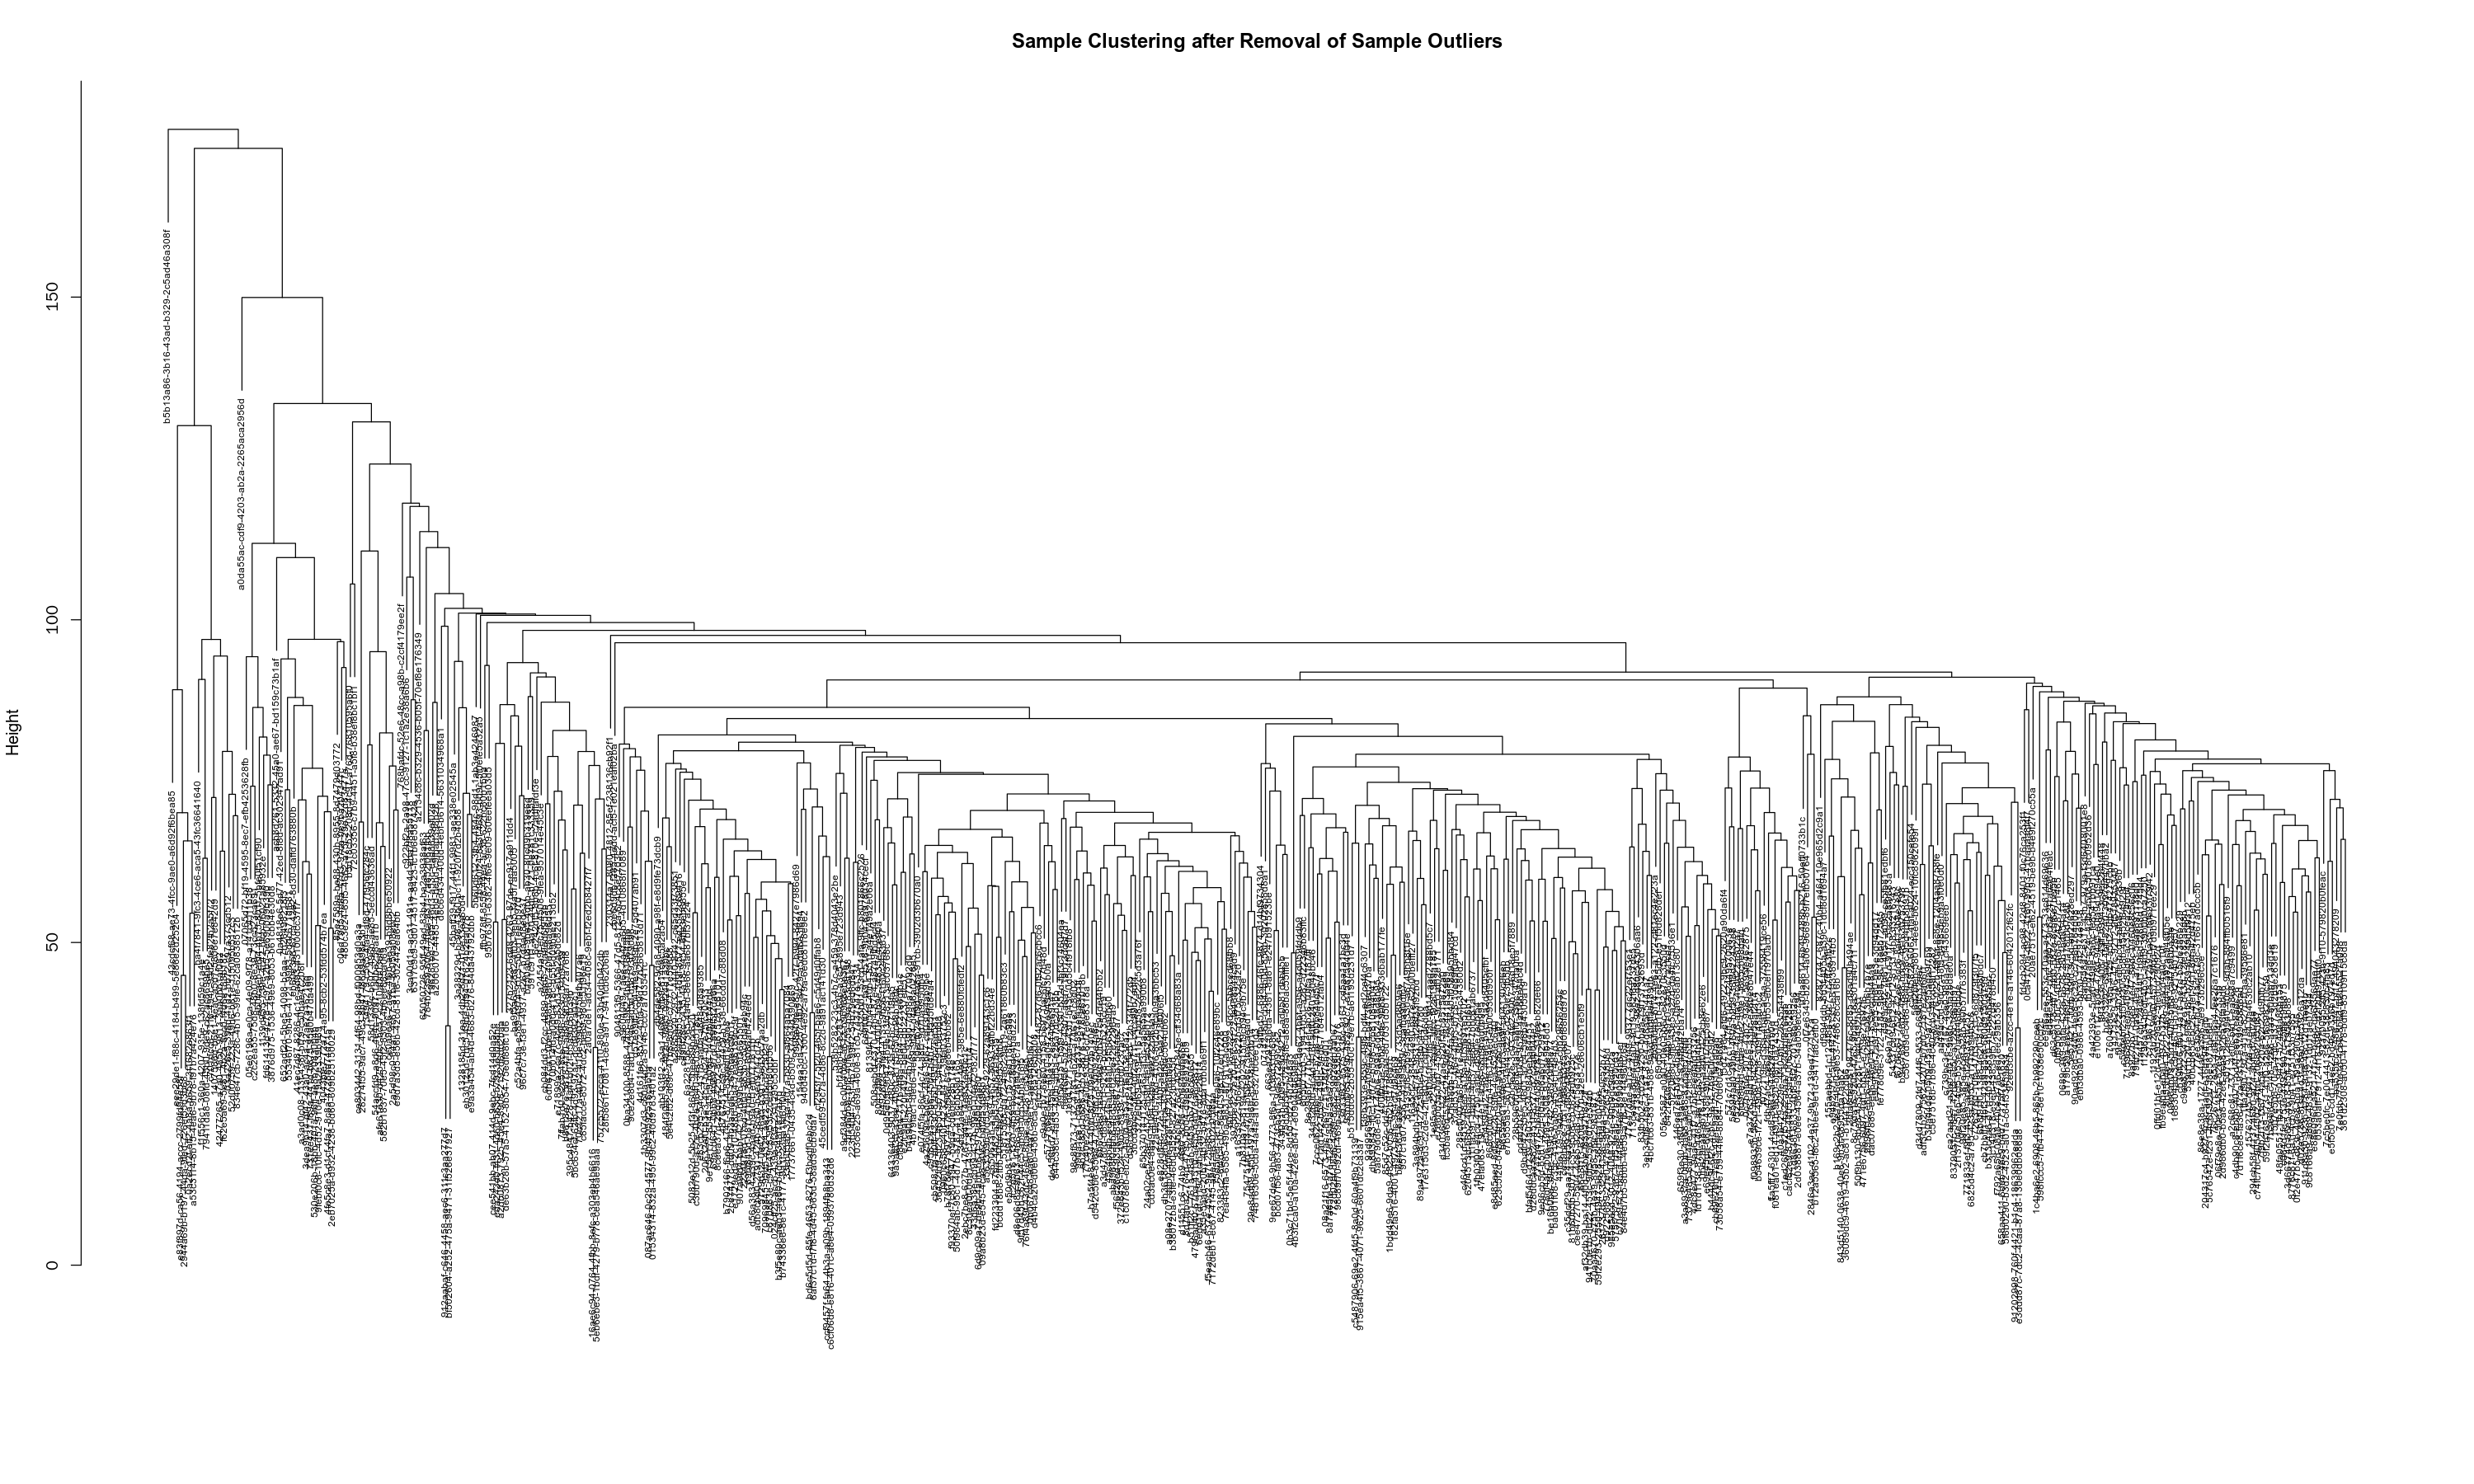

In [322]:
sampleTree2 <- hclust(dist(dataExpr4), method = "average")
plot(sampleTree, main = "Sample Clustering after Removal of Sample Outliers", sub = "", xlab = "", cex = 0.6)

In [326]:
dataExpr <- dataExpr4
dataTraitALL <- (ssgsea.data.tumor[,keywords])
dataTraitALL$sampleID <- (ssgsea.data.tumor$external_id)


In [329]:
exprRows <- rownames(dataExpr)
traitRows <- match(exprRows, dataTraitALL$sampleID)
dataTrait <- dataTraitALL[traitRows, -1]
rownames(dataTrait) <- dataTrait$sampleID
head(dataTrait)

,tcga.cgc_case_pathologic_stage,tcga.xml_histological_type,tcga.xml_stage_event_pathologic_stage,tcga.xml_anatomic_neoplasm_subdivision,sampleID
,<chr>,<chr>,<chr>,<chr>,<chr>
98c8f873-7132-4781-ab24-a7461e1c8d02,Stage IIA,Colon Adenocarcinoma,Stage IIA,Ascending Colon,98c8f873-7132-4781-ab24-a7461e1c8d02
ffa5fff7-6301-4cd8-8e63-a4d8294d1b0e,Stage I,Colon Adenocarcinoma,Stage I,Hepatic Flexure,ffa5fff7-6301-4cd8-8e63-a4d8294d1b0e
29e8adb9-3f5d-497a-9a6b-85218ae2db14,Stage II,Colon Adenocarcinoma,Stage II,Sigmoid Colon,29e8adb9-3f5d-497a-9a6b-85218ae2db14
2ebc7be8-627b-4767-a4fe-14e933e40c1c,Stage IIA,Colon Adenocarcinoma,Stage IIA,Sigmoid Colon,2ebc7be8-627b-4767-a4fe-14e933e40c1c
70969845-95d5-4324-ae22-8d8cd725021d,Stage IIIC,Colon Adenocarcinoma,Stage IIIC,Cecum,70969845-95d5-4324-ae22-8d8cd725021d
196281bd-2c05-46d3-a53c-ead8639ef02d,Stage IIA,Colon Adenocarcinoma,Stage IIA,Ascending Colon,196281bd-2c05-46d3-a53c-ead8639ef02d


In [330]:
sampleTree3 <- hclust(dist(dataExpr), method = "average")
traitColors <- numbers2colors(dataTrait, signed = F)

ERROR: Error in numbers2colors(dataTrait, signed = F): 'x' must be numeric. For a factor, please use as.numeric(x) in the call.


In [335]:
table(dataTrait$tcga.cgc_case_pathologic_stage)
table(dataTrait$tcga.xml_anatomic_neoplasm_subdivision)
table(dataTrait$tcga.xml_histological_type)
table(dataTrait$tcga.xml_stage_event_pathologic_stage)


   Stage I   Stage IA   Stage II  Stage IIA  Stage IIB  Stage IIC  Stage III 
        75          1         31        136          7          1         18 
Stage IIIA Stage IIIB Stage IIIC   Stage IV  Stage IVA  Stage IVB 
         7         59         38         43         19          2 


      Ascending Colon                 Cecum      Descending Colon 
                   84                   104                    20 
      Hepatic Flexure Rectosigmoid Junction         Sigmoid Colon 
                   29                     1                   141 
      Splenic Flexure      Transverse Colon 
                    7                    38 


         Colon Adenocarcinoma Colon Mucinous Adenocarcinoma 
                          383                            59 


   Stage I   Stage IA   Stage II  Stage IIA  Stage IIB  Stage IIC  Stage III 
        75          1         32        134          8          1         17 
Stage IIIA Stage IIIB Stage IIIC   Stage IV  Stage IVA  Stage IVB 
         6         59         39         43         19          2 

In [337]:
quantile(ssgsea.data.tumor$score)

0%        25%        50%        75%       100% 
-1.0635517  0.5952188  0.8664085  1.1183128  2.2179077

In [338]:
library(survival)
library(ROCR)


Attaching package: ‘survival’


The following object is masked _by_ ‘.GlobalEnv’:

    cancer




character(0)

In [ ]:
########## Plot Survial curve #############
###########################################

load("OS_TCGA_UM.Rdata")
load("merge.NMF.genelist.Rdata")
OS_TCGA_SKCM <- OS_TCGA_UM
Skcm.expr.data <- OS_TCGA_SKCM$expr
Skcm.pheno.data <- OS_TCGA_SKCM$pheno
genelist_temp <- merge.NMF.genelist$UMM_Module10[1:35]

Skcm.expr.data_temp <- colMeans(Skcm.expr.data[intersect(rownames(Skcm.expr.data),genelist_temp),])
Skcm.expr.data_mean <- median(Skcm.expr.data_temp)
Skcm.expr.data <- data.frame(t(Skcm.expr.data))

Skcm.expr.data$marker.expr <- 1*(Skcm.expr.data_temp >= Skcm.expr.data_mean)
Skcm.expr.data$OS_STATUS <- Skcm.pheno.data$OS_STATUS
Skcm.expr.data$OS_MONTHS <- Skcm.pheno.data$OS_MONTHS
Skcm.expr.data$DFS_STATUS <- Skcm.pheno.data$DFS_STATUS
Skcm.expr.data$DFS_MONTHS <- Skcm.pheno.data$DFS_MONTHS

Skcm.expr.data$OS_MONTHS[which(Skcm.expr.data$OS_MONTHS == "[Not Available]")] <- NA
Skcm.expr.data$OS_MONTHS <- as.numeric(Skcm.expr.data$OS_MONTHS)

data_os <- Skcm.expr.data
# data_os$OS_STATUS <- as.numeric(data_os$OS_STATUS)
data_os$OS_STATUS <- 1
data_os$OS_STATUS[grep("LIVING",data_os$OS_STATUS)] <- 0

attach(data_os)
m = Surv(OS_MONTHS,OS_STATUS)
 summary(coxph(m~marker.expr,data = data_os))
        
logt <- survdiff(m~marker.expr,data = data_os)
p.val <- 1 - pchisq(logt$chisq, length(logt$n) - 1)
p.val <- format(p.val,digits=3)
p.val_os <- p.val
        
coxmodel <- coxph(m~marker.expr,data = data_os)
fit <- summary(coxmodel)
HR <- fit$conf.int[1];
HR_os <- as.numeric(format(HR,digits=3))
low95_os <- fit$conf.int[3]; low95_os<- format(low95_os,digits=3)
up95_os <- fit$conf.int[4]; up95_os<- format(up95_os,digits=3)

kme <- survfit(formula = m ~ marker.expr, data = data_os)

options(repr.plot.width = 10, repr.plot.height = 10)
par(mar = c(8,5,5,2))
plot(kme,lty = c('solid','solid'),col=c('black','blue'),lwd = c(5,5),cex.axis = 2,cex.lab = 3.5,cex.main=3,
     xaxs='i',yaxs="i",xaxt = "n",yaxt="n",mark.time = T)

axis(side = 1,
     at = c(0,100,200,300,400),
     labels = c(0,100,200,300,
    tick = 0.1,
     cex.axis=2)

axis(side = 2,
     at = c(0,.2,.4,.6,.8,1),
     labels = c(0,0.2,0.4,0.6,0.8,1),
     tick = 0.1,
     cex.axis=2)
title(ylab="Disease-specific survival", mgp=c(3,1,0), cex.lab=2.2)
title(xlab="Time (months)", mgp=c(3,1,0), cex.lab=2.2)
legend('topright',c(paste('Low risk (',length(which(marker.expr==0))," patients",')',sep = ""),paste('High risk (',length(which(marker.expr==1))," patients",')',sep = "")),lty = c('solid','solid'),col=c('black','blue'),cex = 2,lwd = c(2,2))
text(250,0.6,paste("p = ",p.val_os, "\nHR ",HR_os," (",low95_os,"-",up95_os,")",sep = ""),cex = 2)
detach(data_os)

In [107]:
all(sapply(TPM.gene_name.final, is.numeric))

[1] TRUE

In [73]:
head(data.frame(dt.tcga@rowRanges) %>% select(gene_id, gene_name))
presigs

,gene_id,gene_name
,<chr>,<chr>
1,ENSG00000278704.1,BX004987.1
2,ENSG00000277400.1,AC145212.2
3,ENSG00000274847.1,AC145212.1
4,ENSG00000277428.1,Y_RNA
5,ENSG00000276256.1,AC011043.1
6,ENSG00000278198.1,AC011043.2


STAD BRCA  CRC ESCA LIHC LUAD PAAD PRAD 
"M5" "M4" "M9" "M1" "M2" "M1" "M4" "M6"

In [11]:
library(stringr)
library(readr)
gtf_in <- read_delim("gencode.v26.annotation.gtf.gz",
"\t", escape_double = FALSE, col_names = FALSE,
comment = "#", trim_ws = TRUE)
gtf_in <- gtf_in[gtf_in$X3=="gene",]#第三列feature是gene的保留下来
gene_info <- data.frame(str_split_fixed(unique(gtf_in$X9),";",5))
gene_info2 <- unique(data.frame("gene_id"=str_split_fixed(gene_info$X1,'"',3)[,2],
                         "gene_name"=str_split_fixed(gene_info$X3,'"',3)[,2],
                         "gene_biotype"=str_split_fixed(gene_info$X5,'"',3)[,2]))

Rows: 2604486 Columns: 9
── Column specification ─────────────────────────────────────────────────────────
Delimiter: "\t"
chr (7): X1, X2, X3, X6, X7, X8, X9
dbl (2): X4, X5

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [16]:
gene_info2 %>%
    full_join(data.frame(dt.tcga@rowRanges), "gene_id") %>%
    filter(gene_name.x != gene_name.y)

gene_id,gene_name.x,gene_biotype,seqnames,start,end,width,strand,source,type,bp_length,phase,gene_type,gene_name.y,level,havana_gene,tag
<chr>,<chr>,<chr>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>


In [334]:
library(refGenome)

载入需要的程辑包：RSQLite

Warning message in namespaceImportFrom(ns, loadNamespace(j <- i[[1L]], c(lib.loc, :
“重新评估被中断的许诺”
Warning message in namespaceImportFrom(ns, loadNamespace(j <- i[[1L]], c(lib.loc, :
“internal error -3 in R_decompress1”
Error: package or namespace load failed for ‘RSQLite’ in namespaceImportFrom(ns, loadNamespace(j <- i[[1L]], c(lib.loc, :
 lazy-load database '/home/zzy20/anaconda3/envs/env2022/lib/R/library/fastmap/R/fastmap.rdb' is corrupt



ERROR: Error: 无法载入程辑包‘RSQLite’


In [255]:
head(dt.pp)

,X,GTEX.13FHP.2426.SM.5KLZ5,GTEX.11ONC.2026.SM.5HL61,GTEX.ZYFC.2626.SM.5NQ6S,GTEX.12KS4.2426.SM.5LU8P,GTEX.111VG.2226.SM.5N9DU,GTEX.147JS.2526.SM.5S2Q8,GTEX.XMK1.1726.SM.4B64Z,GTEX.Z93S.2426.SM.5HL8N,GTEX.Y8E4.2426.SM.4WWDN,⋯,TCGA.NH.A8F7.01,TCGA.NH.A8F8.01,TCGA.QG.A5YV.01,TCGA.QG.A5YX.01,TCGA.QG.A5Z1.01,TCGA.QG.A5Z2.01,TCGA.QL.A97D.01,TCGA.RU.A8FL.01,TCGA.SS.A7HO.01,TCGA.T9.A92H.01
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSG00000000003.14,552,440,471,1002,719,513,4694,539,1583,⋯,10101,4579,8394,10528,12255,3358,5242,10573,7894,8240
2,ENSG00000000005.5,40,11,7,19,13,10,34,9,35,⋯,72,16,171,41,79,24,175,23,2,37
3,ENSG00000000419.12,757,516,642,553,640,532,1147,803,749,⋯,3624,3543,3672,2313,4357,1729,3341,2757,2955,4345
4,ENSG00000000457.13,556,258,508,487,416,360,1000,632,681,⋯,748,727,1166,958,932,1373,808,970,776,724
5,ENSG00000000460.16,193,150,228,239,165,195,346,233,194,⋯,476,466,1363,692,701,673,775,649,890,730
6,ENSG00000000938.12,305,150,132,302,196,310,692,210,177,⋯,81,211,112,112,227,240,116,34,112,58


In [254]:
dt.pp <- read.csv("pp.csv")

In [259]:
# head(data.frame(dt.tcga@rowRanges$))
rownames(dt.pp) <- dt.pp$X
dt.pp <- dt.pp[,-1]
head(dt.pp)

,GTEX.13FHP.2426.SM.5KLZ5,GTEX.11ONC.2026.SM.5HL61,GTEX.ZYFC.2626.SM.5NQ6S,GTEX.12KS4.2426.SM.5LU8P,GTEX.111VG.2226.SM.5N9DU,GTEX.147JS.2526.SM.5S2Q8,GTEX.XMK1.1726.SM.4B64Z,GTEX.Z93S.2426.SM.5HL8N,GTEX.Y8E4.2426.SM.4WWDN,GTEX.ZAB4.2226.SM.5HL97,⋯,TCGA.NH.A8F7.01,TCGA.NH.A8F8.01,TCGA.QG.A5YV.01,TCGA.QG.A5YX.01,TCGA.QG.A5Z1.01,TCGA.QG.A5Z2.01,TCGA.QL.A97D.01,TCGA.RU.A8FL.01,TCGA.SS.A7HO.01,TCGA.T9.A92H.01
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003.14,552,440,471,1002,719,513,4694,539,1583,432,⋯,10101,4579,8394,10528,12255,3358,5242,10573,7894,8240
ENSG00000000005.5,40,11,7,19,13,10,34,9,35,24,⋯,72,16,171,41,79,24,175,23,2,37
ENSG00000000419.12,757,516,642,553,640,532,1147,803,749,490,⋯,3624,3543,3672,2313,4357,1729,3341,2757,2955,4345
ENSG00000000457.13,556,258,508,487,416,360,1000,632,681,391,⋯,748,727,1166,958,932,1373,808,970,776,724
ENSG00000000460.16,193,150,228,239,165,195,346,233,194,162,⋯,476,466,1363,692,701,673,775,649,890,730
ENSG00000000938.12,305,150,132,302,196,310,692,210,177,344,⋯,81,211,112,112,227,240,116,34,112,58


In [266]:
recount3_cases <- gsub("-", ".", substr(dt.tcga@colData$tcga.tcga_barcode, 1, 15))
length(recount3_cases)
common_case <- intersect(colnames(dt.pp), recount3_cases)
length(common_case)
common_gene <- intersect(rownames(dt.pp), rownames(dt.tcga))
length(common_gene)

[1] 546

[1] 244

[1] 54363

In [289]:
library("factoextra")

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [277]:
td.tcga <- data.frame(dt.tcga@colData) %>% filter(substr(tcga.tcga_barcode, 1, 15) %in% gsub("\\.", "-", common_case))

dt.recount <- dt.tcga[common_gene, rownames(td.tcga)]@assays@data$raw_counts
dt.sp <- dt.pp[common_gene, gsub("-", ".", substr(td.tcga$tcga.tcga_barcode, 1, 15))]
colnames(dt.recount) <- colnames(dt.sp)

In [305]:
m.recount <- t(dt.recount); m.recount <- m.recount[, colMeans(m.recount) != 0]
m.sp <- t(dt.sp); m.sp <- m.sp[, colMeans(m.sp) != 0]

In [301]:
pca.1 <- prcomp(m.recount, center = TRUE,scale. = TRUE)

In [308]:
pca.2 <- prcomp(m.sp, center = TRUE,scale. = TRUE)

In [302]:
head(pca.1$x)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280
TCGA.A6.4105.01,-17.18821,11.6660383,6.460634,-11.557511,-0.002918135,12.196137,-2.781850,2.778904,-3.90681,6.28496942,⋯,0.5799485,-1.7728465,5.7002172,-1.8714728,0.3348347,-0.4567824,0.4663720,-0.55152334,-0.27303576,-1.323594e-14
TCGA.AA.3506.01,11.11946,205.1290339,12.132967,4.010614,-6.243218877,7.889105,5.487899,-16.439109,15.84677,-15.09886258,⋯,1.3385471,4.4330741,0.0217763,2.4740492,4.2759846,6.4596312,0.8986561,3.53869916,47.74598668,-7.771561e-15
TCGA.AA.3511.01,-21.39475,-20.6285117,2.312266,-9.034210,0.476897111,-2.136612,0.403112,9.289231,17.58765,-28.03828752,⋯,1.2885051,-0.3115853,-0.5898391,1.5600042,1.7862470,0.4372447,-0.6501599,0.65382208,0.04609692,-2.393571e-14
TCGA.D5.6920.01,-27.77023,-36.9838131,1.215579,-22.845968,11.015866618,-8.464448,-29.423663,25.042061,-10.37312,0.05497708,⋯,2.8790592,-0.5008899,1.9150956,0.4220499,-0.1089588,1.0064585,-0.8733790,0.69461139,0.29698869,1.122019e-14
TCGA.A6.5664.01,-12.87975,-0.7472318,7.592649,-66.676499,5.960203035,13.983706,-6.300953,15.859011,-13.85660,-3.20600487,⋯,-0.5524531,0.2665421,0.2563363,-0.5550412,-0.8577167,0.1601634,-0.4926543,-0.04991154,-0.01942693,-1.459943e-14
TCGA.AZ.4315.01,-44.85446,-18.5389464,20.909201,46.481662,-7.248981911,20.231381,-10.457422,14.688864,-62.94982,55.97479104,⋯,-1.0611364,1.3167075,0.9941273,0.5548202,-0.0439562,1.2597458,-1.2516610,-0.58685617,0.09651108,-6.661338e-15


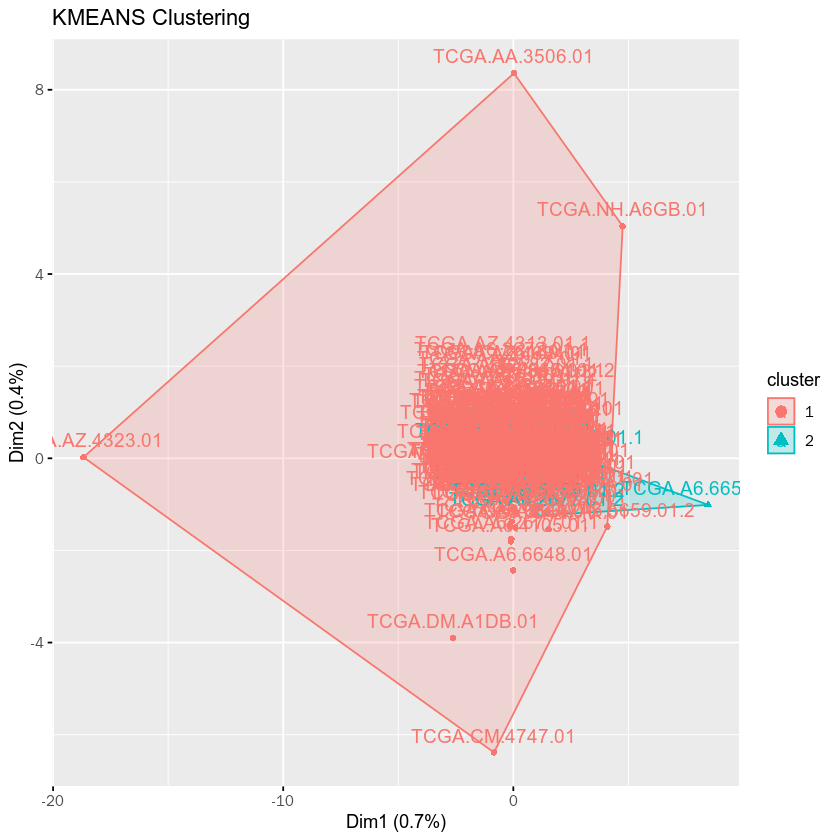

In [303]:
results.1 <- pca.1$x
km1.1 <- eclust(results.1, "kmeans", hc_metric="eucliden",k=2)

In [318]:
table(km1.1$cluster)
table(km1.2$cluster)
which(km1.1$cluster != km1.2$cluster)


  1   2 
270  10 


  1   2 
258  22 

TCGA.A6.2684.01 TCGA.A6.2684.01.1   TCGA.A6.2677.01 TCGA.A6.2684.01.3 
               15                26                43                77 
  TCGA.A6.5665.01   TCGA.A6.3810.01   TCGA.A6.6650.01   TCGA.A6.5656.01 
               79                99               116               121 
TCGA.A6.2677.01.1 TCGA.A6.3810.01.2 TCGA.A6.5659.01.1 TCGA.A6.2672.01.1 
              151               155               156               188 
TCGA.A6.5659.01.2 TCGA.A6.6650.01.2 
              252               275

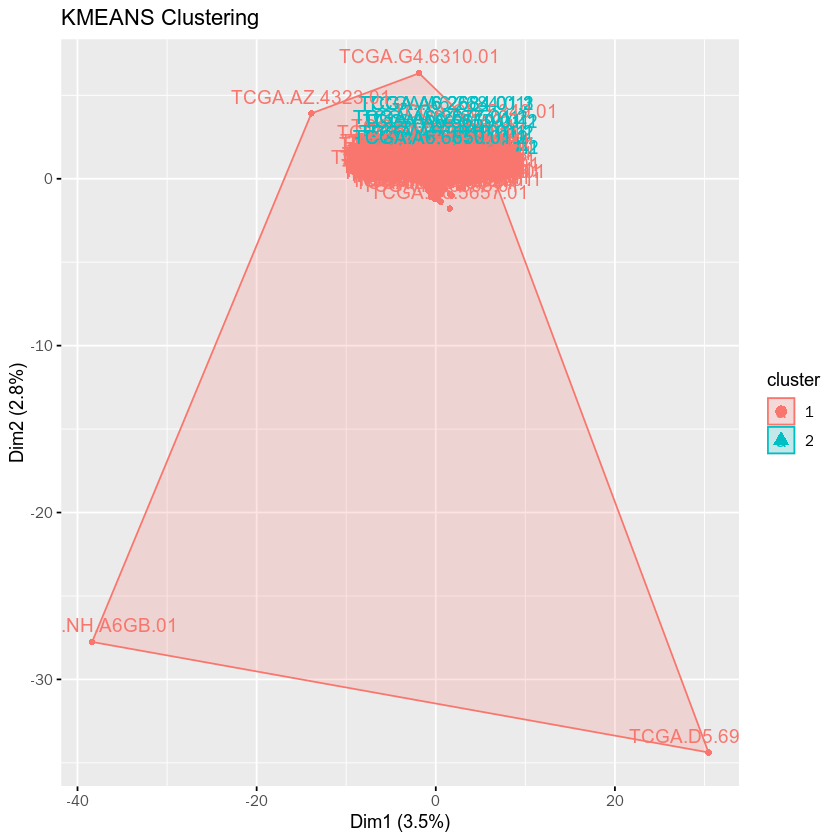

In [309]:
results.2 <- pca.2$x
km1.2 <- eclust(results.2, "kmeans", hc_metric="eucliden",k=2)

In [120]:
head(data.frame(dt.tcga@colData))

,rail_id,external_id,study,tcga.tcga_barcode,tcga.gdc_file_id,tcga.gdc_cases.project.name,tcga.gdc_cases.project.released,tcga.gdc_cases.project.state,tcga.gdc_cases.project.primary_site,tcga.gdc_cases.project.project_id,⋯,recount_seq_qc..distinct_quality_values,recount_seq_qc..bases,recount_seq_qc..a,recount_seq_qc..c,recount_seq_qc..g,recount_seq_qc..t,recount_seq_qc..n,recount_seq_qc.avgq,recount_seq_qc.errq,BigWigURL
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
98c8f873-7132-4781-ab24-a7461e1c8d02,106647,98c8f873-7132-4781-ab24-a7461e1c8d02,COAD,TCGA-A6-4105-01A-02R-1774-07,98c8f873-7132-4781-ab24-a7461e1c8d02,Colon Adenocarcinoma,TRUE,legacy,Colorectal,TCGA-COAD,⋯,38,2457452352,24.5,25.6,25.1,24.8,0.0,37.6,25.3,http://duffel.rail.bio/recount3/human/data_sources/tcga/base_sums/AD/COAD/02/tcga.base_sums.COAD_98c8f873-7132-4781-ab24-a7461e1c8d02.ALL.bw
ffa5fff7-6301-4cd8-8e63-a4d8294d1b0e,106796,ffa5fff7-6301-4cd8-8e63-a4d8294d1b0e,COAD,TCGA-AA-3506-01A-01R-1410-07,ffa5fff7-6301-4cd8-8e63-a4d8294d1b0e,Colon Adenocarcinoma,TRUE,legacy,Colorectal,TCGA-COAD,⋯,39,1024379528,22.3,27.5,27.7,21.9,0.6,36.9,18.4,http://duffel.rail.bio/recount3/human/data_sources/tcga/base_sums/AD/COAD/0E/tcga.base_sums.COAD_ffa5fff7-6301-4cd8-8e63-a4d8294d1b0e.ALL.bw
29e8adb9-3f5d-497a-9a6b-85218ae2db14,107175,29e8adb9-3f5d-497a-9a6b-85218ae2db14,COAD,TCGA-AA-3511-01A-21R-1839-07,29e8adb9-3f5d-497a-9a6b-85218ae2db14,Colon Adenocarcinoma,TRUE,legacy,Colorectal,TCGA-COAD,⋯,38,3146039568,24.7,25.5,24.8,25.0,0.0,37.3,24.7,http://duffel.rail.bio/recount3/human/data_sources/tcga/base_sums/AD/COAD/14/tcga.base_sums.COAD_29e8adb9-3f5d-497a-9a6b-85218ae2db14.ALL.bw
2ebc7be8-627b-4767-a4fe-14e933e40c1c,107293,2ebc7be8-627b-4767-a4fe-14e933e40c1c,COAD,TCGA-D5-6920-01A-11R-1928-07,2ebc7be8-627b-4767-a4fe-14e933e40c1c,Colon Adenocarcinoma,TRUE,legacy,Colorectal,TCGA-COAD,⋯,38,3248787168,24.1,26.0,25.6,24.3,0.0,35.8,22.2,http://duffel.rail.bio/recount3/human/data_sources/tcga/base_sums/AD/COAD/1C/tcga.base_sums.COAD_2ebc7be8-627b-4767-a4fe-14e933e40c1c.ALL.bw
70969845-95d5-4324-ae22-8d8cd725021d,107301,70969845-95d5-4324-ae22-8d8cd725021d,COAD,TCGA-A6-5664-01A-21R-1839-07,70969845-95d5-4324-ae22-8d8cd725021d,Colon Adenocarcinoma,TRUE,legacy,Colorectal,TCGA-COAD,⋯,38,2854030848,24.5,25.7,25.0,24.8,0.0,37.3,24.4,http://duffel.rail.bio/recount3/human/data_sources/tcga/base_sums/AD/COAD/1D/tcga.base_sums.COAD_70969845-95d5-4324-ae22-8d8cd725021d.ALL.bw
196281bd-2c05-46d3-a53c-ead8639ef02d,107812,196281bd-2c05-46d3-a53c-ead8639ef02d,COAD,TCGA-AA-3845-01A-01R-1022-07,196281bd-2c05-46d3-a53c-ead8639ef02d,Colon Adenocarcinoma,TRUE,legacy,Colorectal,TCGA-COAD,⋯,37,1863562864,25.2,24.3,24.3,25.1,1.1,33.4,14.6,http://duffel.rail.bio/recount3/human/data_sources/tcga/base_sums/AD/COAD/2D/tcga.base_sums.COAD_196281bd-2c05-46d3-a53c-ead8639ef02d.ALL.bw


In [116]:
tail(gsub("\\.", "-", colnames(dt.pp)))
head(substr(dt.tcga@colData$tcga.tcga_barcode, start = 1, stop = 15))

[1] "TCGA-QG-A5Z1-01" "TCGA-QG-A5Z2-01" "TCGA-QL-A97D-01" "TCGA-RU-A8FL-01"
[5] "TCGA-SS-A7HO-01" "TCGA-T9-A92H-01"

[1] "TCGA-A6-4105-01" "TCGA-AA-3506-01" "TCGA-AA-3511-01" "TCGA-D5-6920-01"
[5] "TCGA-A6-5664-01" "TCGA-AA-3845-01"

In [ ]:
full_join(ict, ict19, "V2") %>%
    filter(V1.x != V1.y)

In [187]:
ict <- read.table("features.hg38.tsv")
head(ict)
ict19 <- read.table("features.hg19.tsv")
head(ict19)

,V1,V2,V3,V4
,<chr>,<chr>,<chr>,<chr>
1,ENSG00000243485,MIR1302-2HG,Gene,Expression
2,ENSG00000237613,FAM138A,Gene,Expression
3,ENSG00000186092,OR4F5,Gene,Expression
4,ENSG00000238009,AL627309.1,Gene,Expression
5,ENSG00000239945,AL627309.3,Gene,Expression
6,ENSG00000239906,AL627309.2,Gene,Expression


,V1,V2,V3,V4
,<chr>,<chr>,<chr>,<chr>
1,ENSG00000243485,MIR1302-10,Gene,Expression
2,ENSG00000237613,FAM138A,Gene,Expression
3,ENSG00000186092,OR4F5,Gene,Expression
4,ENSG00000238009,RP11-34P13.7,Gene,Expression
5,ENSG00000239945,RP11-34P13.8,Gene,Expression
6,ENSG00000237683,AL627309.1,Gene,Expression


In [252]:
genes <- data.frame(dt.tcga@rowRanges[str_remove(rownames(dt.tcga), "\\..*") %in% ict$V1]) %>%
    transmute(V1 = str_remove(gene_id, "\\..*"), genename_recount3 = gene_name) %>%
    inner_join(ict) %>%
    mutate(genename_recount3 = str_remove(genename_recount3, "\\..*"), V2 = str_remove(V2, "\\..*")) %>%
    filter(genename_recount3 == V2) %>%
#     filter(V1 == "ENSG00000243485") %>%
    full_join(ict19, "V1") %>%
    filter(V2.x == V2.y) %>%
    filter(genename_recount3 %in% dt.pp$X)


dt.gg <- data.frame(dt.tcga@rowRanges) %>% filter(gene_name %in% genes$genename_recount3)
head(dt.gg)

Joining, by = "V1"


,seqnames,start,end,width,strand,source,type,bp_length,phase,gene_id,gene_type,gene_name,level,havana_gene,tag
,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,GL000209.2,2844,11554,8711,-,HAVANA,gene,1035,NA,ENSG00000273735.4,protein_coding,KIR3DL2,2,OTTHUMG00000189013.2,NA
2,GL000209.2,74867,85943,11077,-,HAVANA,gene,1742,NA,ENSG00000274193.4,protein_coding,KIR2DL4,2,OTTHUMG00000188999.1,NA
3,GL000209.2,139698,151260,11563,-,HAVANA,gene,1238,NA,ENSG00000276433.1,protein_coding,KIR3DL3,2,OTTHUMG00000189003.2,NA
4,GL000250.2,168586,189574,20989,-,HAVANA,gene,7987,NA,ENSG00000234495.7,protein_coding,TRIM27,2,OTTHUMG00000148849.1,NA
5,GL000250.2,260409,270941,10533,-,HAVANA,gene,3176,NA,ENSG00000225351.4,protein_coding,ZNF311,2,OTTHUMG00000148791.1,NA
6,GL000250.2,309838,310865,1028,-,HAVANA,gene,1028,NA,ENSG00000226463.1,protein_coding,OR2W1,2,OTTHUMG00000148790.3,NA


In [188]:
badba <- data.frame(dt.tcga@rowRanges[str_remove(rownames(dt.tcga), "\\..*") %in% ict$V1]) %>%
    transmute(V1 = str_remove(gene_id, "\\..*"), genename_recount3 = gene_name) %>%
    inner_join(ict) %>%
    mutate(genename_recount3 = str_remove(genename_recount3, "\\..*"), V2 = str_remove(V2, "\\..*")) %>%
    filter(genename_recount3 != V2) %>%
#     filter(V1 == "ENSG00000243485") %>%
    identity
badbad <- data.frame(dt.tcga@rowRanges[str_remove(rownames(dt.tcga), "\\..*") %in% ict19$V1]) %>%
    transmute(V1 = str_remove(gene_id, "\\..*"), genename_recount3 = gene_name) %>%
    inner_join(ict19) %>%
    mutate(genename_recount3 = str_remove(genename_recount3, "\\..*"), V2 = str_remove(V2, "\\..*")) %>%
    filter(genename_recount3 != V2) %>%
#     filter(V1 == "ENSG00000243485") %>%
    identity()
identical(badba, badbad)

Joining, by = "V1"
Joining, by = "V1"


[1] FALSE

In [238]:

dt.gg <- data.frame(dt.tcga@rowRanges) %>% filter(gene_name %in% genes)
head(dt.gg)
# dt.pp[dt.gg$gene_name,]


,seqnames,start,end,width,strand,source,type,bp_length,phase,gene_id,gene_type,gene_name,level,havana_gene,tag
,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,GL000209.2,2844,11554,8711,-,HAVANA,gene,1035,NA,ENSG00000273735.4,protein_coding,KIR3DL2,2,OTTHUMG00000189013.2,NA
2,GL000209.2,74867,85943,11077,-,HAVANA,gene,1742,NA,ENSG00000274193.4,protein_coding,KIR2DL4,2,OTTHUMG00000188999.1,NA
3,GL000209.2,139698,151260,11563,-,HAVANA,gene,1238,NA,ENSG00000276433.1,protein_coding,KIR3DL3,2,OTTHUMG00000189003.2,NA
4,GL000250.2,168586,189574,20989,-,HAVANA,gene,7987,NA,ENSG00000234495.7,protein_coding,TRIM27,2,OTTHUMG00000148849.1,NA
5,GL000250.2,260409,270941,10533,-,HAVANA,gene,3176,NA,ENSG00000225351.4,protein_coding,ZNF311,2,OTTHUMG00000148791.1,NA
6,GL000250.2,309838,310865,1028,-,HAVANA,gene,1028,NA,ENSG00000226463.1,protein_coding,OR2W1,2,OTTHUMG00000148790.3,NA


In [ ]:
data.frame(dt.tcga@rowRanges[str_remove(rownames(dt.tcga), "\\..*") %in% ict19$V1]) %>%
    transmute(V1 = str_remove(gene_id, "\\..*"), genename_recount3 = gene_name) %>%
    inner_join(ict19) %>%
    mutate(genename_recount3 = str_remove(genename_recount3, "\\..*"), V2 = str_remove(V2, "\\..*")) %>%
    filter(genename_recount3 != V2) %>%
#     filter(V1 == "ENSG00000243485") %>%
    identity()

In [ ]:

td.tcga <- data.frame(dt.tcga@colData) %>%
    dplyr::filter(substr(tcga.tcga_barcode, start = 1, stop = 15) %in% gsub("\\.", "-", colnames(dt.pp)))
common_gene <- which(dt.tcga@rowRanges$gene_name %in% dt.pp$X)
td.tcga <- dt.tcga[dt.gg$gene_id, rownames(td.tcga)]
td.tcga
rownames(dt.pp) <- dt.pp$X
head(dt.pp[dt.gg$gene_name, gsub("-", ".", substr(td.tcga@colData$tcga.tcga_barcode, start = 1, stop = 15))])
head(td.tcga@assays@data$raw_counts)
head(td.tcga@rowRanges[,'gene_name'])
head((td.tcga@colData))
dim(dt.tcga)
dim(dt.tt)

In [133]:
head(dt.pp)

,X,GTEX.13FHP.2426.SM.5KLZ5,GTEX.11ONC.2026.SM.5HL61,GTEX.ZYFC.2626.SM.5NQ6S,GTEX.12KS4.2426.SM.5LU8P,GTEX.111VG.2226.SM.5N9DU,GTEX.147JS.2526.SM.5S2Q8,GTEX.XMK1.1726.SM.4B64Z,GTEX.Z93S.2426.SM.5HL8N,GTEX.Y8E4.2426.SM.4WWDN,⋯,TCGA.NH.A8F7.01,TCGA.NH.A8F8.01,TCGA.QG.A5YV.01,TCGA.QG.A5YX.01,TCGA.QG.A5Z1.01,TCGA.QG.A5Z2.01,TCGA.QL.A97D.01,TCGA.RU.A8FL.01,TCGA.SS.A7HO.01,TCGA.T9.A92H.01
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,TSPAN6,552,440,471,1002,719,513,4694,539,1583,⋯,10101,4579,8394,10528,12255,3358,5242,10573,7894,8240
2,TNMD,40,11,7,19,13,10,34,9,35,⋯,72,16,171,41,79,24,175,23,2,37
3,DPM1,757,516,642,553,640,532,1147,803,749,⋯,3624,3543,3672,2313,4357,1729,3341,2757,2955,4345
4,SCYL3,556,258,508,487,416,360,1000,632,681,⋯,748,727,1166,958,932,1373,808,970,776,724
5,C1orf112,193,150,228,239,165,195,346,233,194,⋯,476,466,1363,692,701,673,775,649,890,730
6,FGR,305,150,132,302,196,310,692,210,177,⋯,81,211,112,112,227,240,116,34,112,58


In [99]:
dt.tt <- data.frame(dt.tcga@assays@data$raw_counts) %>%
    rownames_to_column("gene_id") %>%
    inner_join(data.frame(dt.tcga@rowRanges))
head(dt.tt)

Joining, by = "gene_id"


,gene_id,X98c8f873.7132.4781.ab24.a7461e1c8d02,ffa5fff7.6301.4cd8.8e63.a4d8294d1b0e,X29e8adb9.3f5d.497a.9a6b.85218ae2db14,X2ebc7be8.627b.4767.a4fe.14e933e40c1c,X70969845.95d5.4324.ae22.8d8cd725021d,X196281bd.2c05.46d3.a53c.ead8639ef02d,cee541bb.ab07.414d.9ebc.7fcd14d0a52e,X768bafdc.52e6.48cc.a98b.c2cf4179ee2f,X45cedf59.bc7a.4d86.8c2d.9a91ac141d30,⋯,strand,source,type,bp_length,phase,gene_type,gene_name,level,havana_gene,tag
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<fct>,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSG00000278704.1,0,0,0,0,0,0,0,0,0,⋯,-,ENSEMBL,gene,2237,NA,protein_coding,BX004987.1,3,NA,NA
2,ENSG00000277400.1,0,0,0,0,0,0,0,0,0,⋯,-,ENSEMBL,gene,2179,NA,protein_coding,AC145212.2,3,NA,NA
3,ENSG00000274847.1,0,0,0,0,0,0,0,0,0,⋯,-,ENSEMBL,gene,1599,NA,protein_coding,AC145212.1,3,NA,NA
4,ENSG00000277428.1,0,0,0,0,0,0,0,0,0,⋯,-,ENSEMBL,gene,101,NA,misc_RNA,Y_RNA,3,NA,NA
5,ENSG00000276256.1,0,0,0,0,0,0,0,0,0,⋯,-,ENSEMBL,gene,2195,NA,protein_coding,AC011043.1,3,NA,NA
6,ENSG00000278198.1,0,0,0,0,0,0,0,0,0,⋯,+,ENSEMBL,gene,1468,NA,protein_coding,AC011043.2,3,NA,NA


In [205]:
lucky <- sample(colnames(dt.tcga), 6)
barcode <- dt.tcga@colData[lucky,]$tcga.tcga_barcode
lucky

[1] "5e4c2f52-d69c-47b8-8d09-c77717e59688"
[2] "d02e5786-8f3a-4d3f-a8eb-4fc5926a12da"
[3] "90ad928d-3440-4eb8-8c29-cc7e6b764d08"
[4] "8a7a65fe-1a7e-42e5-8a5a-55e7733521da"
[5] "69acd641-0bb8-4d69-97d0-899f5f2da66a"
[6] "087ac646-0c29-4577-9b4f-0592516cab5a"

In [213]:
data.frame(dt.tcga@colData[lucky, "tcga.gdc_cases.case_id"])
barcode
lucky


dt.tcga.colData.lucky...tcga.gdc_cases.case_id..
<chr>
2c30dc20-18a8-44f9-ab10-558c1e5634dc
01240896-3f3f-4bf9-9799-55c87bfacf36
4a785dc7-f5f6-4607-a19d-e6354b2fb5a9
a9cb21d1-4c4a-4f30-ad4d-c54bed26f187
5e7074a6-5011-4dc5-950c-41365dbc6d09
e5921d6b-51cf-44be-b295-610cf7c3a69a


[1] "TCGA-AY-6196-01A-11R-1723-07" "TCGA-F4-6854-01A-11R-1928-07"
[3] "TCGA-F4-6808-01A-11R-1839-07" "TCGA-AA-3975-01A-01R-1022-07"
[5] "TCGA-AD-6964-01A-11R-1928-07" "TCGA-A6-2685-01A-01R-1410-07"

[1] "5e4c2f52-d69c-47b8-8d09-c77717e59688"
[2] "d02e5786-8f3a-4d3f-a8eb-4fc5926a12da"
[3] "90ad928d-3440-4eb8-8c29-cc7e6b764d08"
[4] "8a7a65fe-1a7e-42e5-8a5a-55e7733521da"
[5] "69acd641-0bb8-4d69-97d0-899f5f2da66a"
[6] "087ac646-0c29-4577-9b4f-0592516cab5a"

In [214]:
data.frame(dt.tcga@colData) %>% filter(tcga.gdc_cases.case_id == "2c30dc20-18a8-44f9-ab10-558c1e5634dc")

,rail_id,external_id,study,tcga.tcga_barcode,tcga.gdc_file_id,tcga.gdc_cases.project.name,tcga.gdc_cases.project.released,tcga.gdc_cases.project.state,tcga.gdc_cases.project.primary_site,tcga.gdc_cases.project.project_id,⋯,recount_seq_qc..distinct_quality_values,recount_seq_qc..bases,recount_seq_qc..a,recount_seq_qc..c,recount_seq_qc..g,recount_seq_qc..t,recount_seq_qc..n,recount_seq_qc.avgq,recount_seq_qc.errq,BigWigURL
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
5e4c2f52-d69c-47b8-8d09-c77717e59688,55395,5e4c2f52-d69c-47b8-8d09-c77717e59688,COAD,TCGA-AY-6196-01A-11R-1723-07,5e4c2f52-d69c-47b8-8d09-c77717e59688,Colon Adenocarcinoma,TRUE,legacy,Colorectal,TCGA-COAD,⋯,38,2308885824,24.3,25.8,25.3,24.6,0,37.7,25.6,http://duffel.rail.bio/recount3/human/data_sources/tcga/base_sums/AD/COAD/88/tcga.base_sums.COAD_5e4c2f52-d69c-47b8-8d09-c77717e59688.ALL.bw


In [216]:
dt.tcga@rowRanges

GRanges object with 63856 ranges and 10 metadata columns:
                             seqnames            ranges strand |   source
                                <Rle>         <IRanges>  <Rle> | <factor>
         ENSG00000278704.1 GL000009.2       56140-58376      - |  ENSEMBL
         ENSG00000277400.1 GL000194.1      53590-115018      - |  ENSEMBL
         ENSG00000274847.1 GL000194.1      53594-115055      - |  ENSEMBL
         ENSG00000277428.1 GL000195.1       37434-37534      - |  ENSEMBL
         ENSG00000276256.1 GL000195.1       42939-49164      - |  ENSEMBL
                       ...        ...               ...    ... .      ...
  ENSG00000124334.17_PAR_Y       chrY 57184101-57197337      + |   HAVANA
  ENSG00000185203.12_PAR_Y       chrY 57201143-57203357      - |   HAVANA
   ENSG00000270726.6_PAR_Y       chrY 57190738-57208756      + |   HAVANA
  ENSG00000182484.15_PAR_Y       chrY 57207346-57212230      + |   HAVANA
   ENSG00000227159.8_PAR_Y       chrY 57212184-5721439